# Weak Coin Flipping | Algorithm to find the Unitary

The code is based on the recursive Elliptic Monotone Align (EMA) Algorithm described in my fifth progress report.

Update: The earlier algorithm doesn't work for $n + 1 \to n$ transitions (let alone even more general ones). Possible fixes are described in my notes (see the sixth report to get some reference).

In [1]:
%matplotlib notebook

from math import factorial
import numpy as np
import scipy.linalg as linalg
from scipy.special import gammaln
#from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import basinhopping
from scipy.optimize import bisect
from scipy.optimize import brenth
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Ellipse

## Global parameters

This should include things like the maximum $x$ that is used to represent an "arbitrarily large" $x$.

In [2]:
class gPar:
    xmax = 1E5

## Mochon's Assignment Generator (current version) 

For a set of coordinates {$x_i$} Mochon's assignment is given by $$P(x_i) = \frac{f(x_i)}{\prod_{j\neq i} (x_i - x_j) }$$ where the points for which $P(x_i)>0$ are supposed to be the final points and points with $P(x_i)<0$ correspond to initial points.

We restrict to the kind of points Mochon uses in his TIPG. This involves $2n+1$ points, $n+1$ points initially ($n$ on the ladder and $1$ on the axis) and $n$ points finally. The $2n$ points are distributed symmetrically about the diagonal (no point on the diagonal though).

NB: The weights this generates would be un-normalised but the ellipse solver automatically normalises.

In [5]:
l = ladder(n=4,pivot=20,Δ=1.1,trunc=True)
r = rung(l)
r.selfEval(True)
print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg)
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)

Working
this is k 5
and this is r.n + 1 5
Lattice
 [  0.   15.6  16.7  17.8  18.9  21.1  22.2  23.3  24.4] 
Prob
 [ -1.01363403e+01  -1.21634970e+10   8.31067208e+10  -2.18950865e+11
   2.45373890e+11  -3.02301682e+11   3.32765908e+11  -1.56230097e+11
   2.83996222e+10]
Initial coordinates
 [[  0.    0.    0.    0.    0. ]
 [  0.   15.6   0.    0.    0. ]
 [  0.    0.   17.8   0.    0. ]
 [  0.    0.    0.   21.1   0. ]
 [  0.    0.    0.    0.   23.3]] 
Initial prob
 [  3.83378218e-06   1.32805503e-01   5.63456220e-01   6.62074905e-01
   4.75958619e-01]
Final coordinates
 [[  1.67000000e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   1.89000000e+01   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   2.22000000e+01   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.44000000e+01
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.000

In [3]:
class ladder:
    def __init__(l,n=4,pivot=50,Δ=0.2,x0=2.0,Γ0=1000,xmax=gPar.xmax,trunc=True):
        l.n = n
        l.pivot = pivot*1.0
        l.Δ = Δ*1.0
        l.x0 = x0*1.0
        l.Γ0 = Γ0*1.0
        l.xmax = xmax
        l.trunc = trunc
class rung:
    def __init__(r,l):
        r.n=l.n                # total number of points is 2n+1
        r.size = l.n+1         # this is the size of the arrays; the g array will have n+1 points and the h will have n but I pad an extra point
        r.pivot = l.pivot      # making sure it is in fact
        r.Δ = l.Δ              # lattice spacing
        
        r.Γ0 = l.Γ0  # this is the first point on the right where we start killing to terminate the ladder (n points killed)
        r.x0 = l.x0  # we start killing points before this one (n-1)
        
        r.xmax = l.xmax # this is the 1/ε value with ε ~ 0
        
        r.p = np.zeros(2*r.n+1)
        r.x = np.zeros(2*r.n+1)
        
        r.sqpg = np.zeros(r.n+1)
        r.sqph = np.zeros(r.n+1)
        
        r.xg = np.zeros((r.n+1,r.n+1))
        r.xh = np.eye(r.n+1)*r.xmax #np.zeros((r.n+1,r.n+1))
    
        r.trunc=l.trunc
    def f(r,x):
        f= -1.0 #(-1.0)**(r.n - 1)
        for i in range(1,r.n): #will go till n-1
            f*=(r.x0 - r.Δ*i - x) #truncates the left
            f*=(r.Γ0 + r.Δ*i - x) #truncates the right
        
        f *= (r.Γ0 + r.Δ*r.n - x) #the right needs to be fully truncated
        return f
    
    def evalP(r,i):
        p_i = 1.0  #r.Δ ** n #n! to keep things from exploding; factorial(r.n)
        for j in range(0,2*r.n + 1):
            if(i != j):
                p_i *= 1.0/(r.x[i] - r.x[j])
        if(r.trunc==True):
            p_i *= r.f(r.x[i])
        else:
            p_i *= -1.0
        return p_i
    
    def selfEval(r,debug=False):
        if(debug):
            print("Working")
        
        #Generate the lattice
        r.x[0] = 0 #The axis point
        i=1
        for j in range(-r.n,r.n+1):  #should go -n -n+1 .. n-1, n #because the last one is not included
            if(j!=0):
                r.x[i] = r.pivot + j*r.Δ
                i+=1
        

        j=0
        k=0
        #evaluate the probabilities and separate to x_g and x_h
        for i in range(0,2*r.n + 1):
            r.p[i] = r.evalP(i)
            if(np.abs(r.p[i]) > 1E-15 ): #If the probability is non-zero (modulo numerical errors)
                if(r.p[i]>0): #if positive, it is a final point
                    r.xh[j][j]=r.x[i]
                    r.sqph[j]=np.sqrt(r.p[i])
                    j+=1
                elif(r.p[i]<0): #if negative, it is an initial point
                    r.xg[k][k]=r.x[i]
                    r.sqpg[k]=np.sqrt(-r.p[i])
                    k+=1
        
        #padding the unused points    
        if(debug==True):
            print("this is k",k)
            print("and this is r.n + 1",r.n+1)
        for m in range(j,r.n + 1):
            r.xh[m][m]=r.xmax
        
        r.sqpg = r.sqpg / np.sqrt(r.sqpg.dot(r.sqpg))
        r.sqph = r.sqph / np.sqrt(r.sqph.dot(r.sqph))
        #This one is unnecessary
        #for m in range(k,r.n + 1):
        #    r.xg[m]=0


## Legacy Code (generating Mochon's denomenator based coordinates)

While this is legacy code, it uses log of gamma functions to cleverly evaluate symmetric ladders and can hence handle much larger numbers (all the way to ~60 points I think).

In [4]:
%%capture 
##This is to suppress any outputs


#this one is legacy
np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
#np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
#41
m=9 #total number of points involved in the transition

mm=int(m/2) # number of h points = number of g points on the ladder

x=np.zeros(m)
p=np.zeros(m)

xg = np.zeros(mm+1)
xh = np.zeros(mm+1)

sqpg = np.zeros(mm+1)
sqph = np.zeros(mm+1)


gDiag = np.zeros((mm+1,mm+1))
hDiag = np.zeros((mm+1,mm+1))
U = np.zeros((mm+1,mm+1))
Θ = np.zeros((mm+1,mm+1))

#50 and 0.2
y=100
δy=0.2

####
def evalP(k):
	# return 1.0/k
	# return 1.0*factorial(mm)*factorial(mm)*k/(factorial(mm+k)*factorial(mm-k)) #old implementation for k/(n-k)!(n+k)!

	#n!=exp(gammaln(n+1))
	# return 1.0*np.exp(2*gammaln(mm+1) - gammaln(mm+k  +1) - gammaln((mm+1)-k  +1) )*k*(k+1) #*(k+2)*(k+3)*(k+4) #Worked almost for n=41
	# return 1.0*np.exp(2*gammaln(mm+1) - gammaln((mm+3)+k  +1) - gammaln((mm)-k  +1) )*k*(k+1)  #works for n=41, 0.0000231
	#return 1.0*np.exp(2*gammaln(mm+1) - gammaln((mm+2)+k  +1) - gammaln((mm)-k  +1) )*k*(k+1)  #works for n=41, 0.0000181
	# return 1.0*np.exp(2*gammaln(mm+1) - gammaln((mm+1)+k  +1) - gammaln((mm)-k  +1) )*k*(k+1)  #works for n=41, 0.0000125

	return 1.0*np.exp(2*gammaln(mm+1) - gammaln(mm+k+1) - gammaln(mm-k+1) )*k #k/(n-k)!(n+k)! scheme, close but doesn't work for n=41 (EDIT 2: the distribution is correct) (EDIT: the distribution might be slightly wrong)
	
	# return 1.0*np.exp(2*gammaln(mm+1) - gammaln(mm+k+1) - gammaln(mm-k+1) ) #gaussian: arises from assuming a uniform lattice in mochon's distribution

	#was trying to generalise
	# j=1
	# return 1.0*np.exp(2*gammaln(mm+1) - gammaln(mm+k+1) - (gammaln(mm+j) - gammaln((mm+j)-k)) )*k*(k+1) #*(k+2)*(k+3)*(k+4)


	# # #Example1, works if shifted
	# y=abs(k-mm/2) #-mm
	# return 1.0*np.exp(-(4*y/mm)**2) #with y=k, this is a nice bell curve but it works for k-mm/2 where it has two lumps
	# taking exp(-(3*y/mm)**2) makes it get closer to the x-axis (for 4,5 etc.); the closer it gets more vulnerable does the certificate get

	# return 1.0*np.exp(-(4.0*y/mm)**2) #with y=k, this is a nice bell curve and it works; just no zero probability points;

	# return 1.0*np.exp(-(2.0*y/mm)**2.5) #with y=k, this is a nice bell curve
	# return 1.0*np.exp(-(4.0*y/mm)**2) #with y=k, this is a nice bell curve	
	# return 1.0*(mm-k+1)**2 #sort of linear, because \sqrt{pg} is used


for i,xI in enumerate(x):
	if i==0:
		x[0]=0
		p[0]=0 #crude approximation
	elif(i<= mm):
		x[i]=y + ( - (mm-i+1) )*δy
		p[i]= evalP(mm-i + 1) #* (1-x[i]) * (2-x[i]) * (3-x[i]) * (4-x[i]) * (5-x[i]) * (6-x[i]) # /x[i] #  * (1-x[i]) * (2-x[i]) * (3-x[i]) * (4-x[i]) * (5-x[i]) * (6-x[i]) #* (11-i)
		p[i]=(-1)**(mm-i) * p[i] ##adding the sign manually because the formula was derived differently
	elif(i>mm):
		x[i]=y + (  + (i-mm) )*δy
		p[i] = evalP(i-mm) #* (1-x[i]) * (2-x[i]) * (3-x[i]) * (4-x[i]) * (5-x[i]) * (6-x[i]) # /x[i] # * (1-x[i]) * (2-x[i]) * (3-x[i]) * (4-x[i]) * (5-x[i]) * (6-x[i])  # * (10-i) #* (11-i)
		p[i]=(-1)**(i-mm) * p[i] ##this is the correct one, I am messing this up in the next line
		#p[i]=(-1)**(mm-i) * p[i]

p0temp=0.0
for i, xI in enumerate(x):
	if i>0:
		p0temp+=p[i]

p[0]=-p0temp

####

print(np.c_[x,p])


#numerics insight; N_h^2 (stolen)
nhsq=0.0
ngsq=0
for i in range(0,m):
	if (p[i]>0):
		nhsq+= p[i]
	else:
		ngsq+= -p[i]
print("Total Prob\t {:10.3f}\n".format(nhsq),ngsq)

print("\n normalised p is \n",p[:]/nhsq,"\n")

#average initial position (stolen)
avg_xg=0.0
for i in range(0,m):
	if(p[i]<0):
		avg_xg += x[i]*p[i]
print("Average x initial \t {:10.3f}\n".format(abs(avg_xg)/nhsq))

#average final position (stolen)
avg_xh=0.0
for i in range(0,m):
	if(p[i]>0):
		avg_xh += x[i]*p[i]
print("Average x final \t {:10.3f}\n".format(abs(avg_xh)/nhsq))

#sanity check (stolen); average should be close to zero 
# (not exactly because I haven't included the factor that encodes the distance from the origin)
avg=0.0 
for i in range(0,m):	
	avg=avg + p[i]*x[i]
avg/=nhsq
diag1=avg
print ("difference in average\t {:10.20f}".format(avg))


##This is the close x method (stolen)
for i in range(2,m,2):
	k=int(i/2)
	if(mm%2 == 0): #means mm+1 is odd; I kill odd number of points before; p[1] is negative (or I could just test for that!)
		xg[k]=x[i-1]
		xh[k]=x[i]
		sqpg[k]= (-p[i-1]/nhsq)**0.5
		sqph[k]=  (p[i]/nhsq)**0.5
	else:
		xg[k]=x[i]
		xh[k]=x[i-1]
		sqpg[k]= (-p[i]/nhsq)**0.5
		sqph[k]=  (p[i-1]/nhsq)**0.5
	#This adds a phase to make the function's derivative continuous
	# if(k>mm/2):
	# 	# xg[k]-=δy
	# 	# xh[k]-=δy
	# 	sqpg[k]=-sqpg[k]
	# 	sqph[k]=-sqph[k]

#Checking if the assignment for pg and ph is correct
print ("Me printing pg and ph\n", np.c_[sqpg**2,sqph**2])
print ("Me printing xg and xh\n", np.c_[xg,xh])

####

for i in range(0,mm+1):
	gDiag[i,i]=xg[i]
	hDiag[i,i]=xh[i]


## The Elliptic Monotone-Align Algorithm (EMA), Implementation

I will start with defining some base classes.

### Some conventions
* The indexing throughout here has been taken to start from 0 (unlike earlier where 0 was ignored and I started from 1)
* A set of $n$-dimensional vectors, $v^{j}$ are represented by 
$$ M^{ij}\doteq 
\left[
\begin{matrix} 
(v^{1})_{1} &(v^{2})_{1} &(v^{3})_{1} &\dots \\
(v^{1})_{2} &(v^{2})_{2} &(v^{3})_{2} &\dots \\
\vdots &\vdots &\vdots \\
(v^{1})_{n} &(v^{2})_{n} &(v^{3})_{n} &\dots \\
\end{matrix} \right] $$

### The Ellipsoid Class

The Ellipsoid class contains the plain old ellipsoid, the direction (and point) of contact and the ability to find tangents/normals at the said point (and also the curvature) with the added twist of a significant ellipsoid. 

[See this](https://math.stackexchange.com/questions/1159928/radius-vs-radius-of-curvature-of-an-ellipse) for understanding the special cases

In [141]:
#Testing the class
e1 = ellipsoid(3)
e1.X = np.array([[2.0,0,0],[0,2,0],[0,0,1]])
e1.Xp = e1.X

e1.v=np.array([2.0,0,0])
e1.selfEval()
print(e1.Xc)

e1 = ellipsoid(2)
e1.X = np.array([[1.0,0],[0,2]])
e1.Xp = e1.X

#e1.v=np.array([1.0,0])
e1.n=np.array([0.0,1])
e1.selfEval(nGiven=True)
print(e1.Xc)

[[ 2.  0.]
 [ 0.  1.]]
[[ 1.]]


C:\Users\toatu\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide
C:\Users\toatu\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in sign


In [5]:
class ellipsoid:
    #the first variable is self being referred to as e (for ellipsoid) to keep things simple
    def __init__(e,size):                
        #Size
        e.Size=size
        
        #This defines the ellipsoid
        e.X = np.zeros((size,size))
        
        #This defines the signficiant ellipsoid; all the tangents and normals need to be evaluated wrt this
        e.Xp = np.zeros((size,size))
                
        #This defines the direction of interest
        e.v = np.zeros(size)
        
        #This defines the contact point in the direction v
        e.c = np.zeros(size)

        #Normal vector at the contact point
        e.n = np.zeros(size)
        
        #Tangent vector at the contact point
        e.t = np.zeros((size,size-1))

        #Combined
        e.nt = np.zeros((size,size))
        
        #Curvatures at the point of contact ordered according to the tangent vectors
        #evaluted above (stored as a diagonal matrix)
        e.Xc = np.zeros((size-1,size-1))

    #This is what happens when you try to print
    def __str__(e):
        print("Ellipsoid with properties\n")
        print("X\n",e.X)
        print("Xp\n",e.Xp)
        print("v\n",e.v)
        print("nt (normal and tangents)\n",e.nt)
        print("Xc\n",e.Xc)
        return " "
    # This populates the tangents (t), the normals (n) and the curvatures (Xc) 
    # using the Weingarten Technique for the X' (=Xp) ellipsoid
    #conv basically means use a convention for finding the "correct" direction of the tangent vector
    def selfEval(e,nGiven=False,conv=True):
        #To find the inverse of the diagonal matrix (there should be a faster way of doing this; find it later)
        e.XpInv = np.zeros_like(e.Xp)
        for i in range (0,e.Size):
            e.XpInv[i,i]=1/e.Xp[i,i]        
        
        #print("e.XpInv\n", e.XpInv)

        #Normalise the position vector
        e.normPosVec()
        
        if(nGiven==False):

            #The contact vector will in general not be normalised (this is how it should be it's an ellipsoid!)
            #note also that it doesn't matter if e.v is normalised or not for this calculation
            e.c = e.v / np.sqrt(e.v.dot(e.Xp.dot(e.v)))

            #print("e.c\n", e.c)

            #The normal vector | this is implicitly computed using the gradiant method
            e.n = e.Xp.dot(e.c) #this is unnormalised
            e.n = e.n / np.sqrt(e.n.dot(e.n))  #this normalises it
        
        #print("e.n\n", e.n)
        
        #The support function
        e.supp = np.sqrt(e.n.dot(e.XpInv.dot(e.n)))
        
        #print("e.supp\n", e.supp)
        
        #The reverse Weingarten map (this contains radii of curvature)
        e.Wr = e.XpInv
        #print("e.Wr\n", e.Wr)
        for i in range (0,e.Size):
            for j in range (0,e.Size):
                e.Wr[i,j] += - e.n[i]*e.n[j] /(e.supp*e.supp*e.Xp[i,i]*e.Xp[j,j])
        #This last step is required but I think it is analytically wrong
        #e.Wr = e.Wr/e.supp
        
        #print("e.Wr\n", e.Wr)
        
        
        #Diagonalise the reverse Weingarten map to get 
        #the new ellipsoid and the tangent vectors
        eigenval,eigenvec = np.linalg.eigh(e.Wr)
        
        #print("Eigenvalues of the Weingarten map ",eigenval)
        
        #set of tangents picked out
        e.t = eigenvec[:,1:]        
        
        #This is to set make sure that in the sub problem, the components of v are again positive
        #This is achieved by adjusting the sign of the tangent vectors accordingly
        #convention=True
        
        if(conv):
            #Convention
            for i in range(0,e.Size-1):
                s = np.sign(e.v.dot(e.t[:,i]))
                if(s!=0):
                    e.t[:,i]*=s #1#s
        else:
            #Special mess
            for i in range(1,e.Size-1):
                s = np.sign(e.v.dot(e.t[:,i]))
                if(s!=0):
                    e.t[:,i]*=-s #-1 #s #1#s
                
                
        #normal + tangent in a single matrix
        #The trouble with the normal evaluated by the Weingarten map is that due to numerical errors it 
        # sometimes gets the overall sign of the normal vector wrong (as the corresponding eigenvalue is very close to zero).
        #For the tangents this is not really the case so it is more reliable there.
        #Therefore I use the gradient based normal calculation.
        e.nt = np.zeros_like(eigenvec)
        e.nt[:,1:] = e.t #eigenvec[:,1:]
        e.nt[:,0] = e.n
        
        #print("The normal vector\n", e.nt[:,0], "and again the normal vector\n",e.n)
        
        e.XcInv = np.diagflat(eigenval[1:])
        e.Xc = np.diagflat(1/eigenval[1:])   #This is the new curvature matrix
        
        #print("e.Xc\n",e.Xc)
        #print("e.t\n",e.t)
        #print("eigenvalues\n",eigenval)
        #print("eigenvectors\n",eigenvec)
    def normPosVec(e):
        e.v = e.v / np.sqrt(e.v.dot(e.v))

$\LaTeX$ Compile me if the Dirac Notation is not rendering correctly
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\langle {#1} | {#2} \rangle}$

### Global minima in range | Basin Hopping extension

Look at the [documentation for scipy](https://docs.scipy.org/doc/scipy/reference/optimize.html) for reference.
The method of interest is called [Basin Hopping](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html#scipy.optimize.basinhopping). The stock version doesn't seem to support bounds (which we need as $\lambda \ge 0$ for our case).
This generalisation is based on [a stack overflow answer](https://stackoverflow.com/questions/21670080/how-to-find-global-minimum-in-python-optimization-with-bounds).



In [4]:
class RandomDisplacementBounds(object):
    """random displacement with bounds"""
    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
        """take a random step but ensure the new position is within the bounds"""
        while True:
            # this could be done in a much more clever way, but it will work for example purposes
            xnew = x + np.random.uniform(-self.stepsize, self.stepsize, np.shape(x))
            if np.all(xnew < self.xmax) and np.all(xnew > self.xmin):
                break
        return xnew

### The Instance Class



This is intended to contain a g-ellipsoid, an h-ellipsoid, a unitary and a basis in which all of this makes sense.

The non-trivial part here is finding the significant operator monotone function. The n-Unitary, $U^{(n)}$, in this case is more straightforward. 

<This is simply supposed to ensure that $\bra{u_h}U^{(n)}\ket{v_g}=\braket{u_h}{v_h}>

δ is 1.25531661812
[0.3102725 0.9506476]
[0.6094103 0.7928550]


<IPython.core.display.Javascript object>


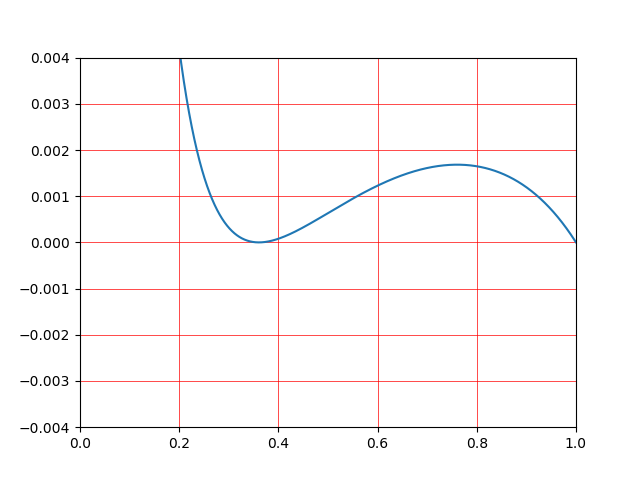

f(0) and f(1) are  -3.71119285122 2.22044604925e-16
Best scaling 1.0
Value at best scaling 2.22044604925e-16
λ optimisation result
 0.360727996922
λ_min 0
Before Wiggle-v
v is  [0.3102725 0.9506476]
w is  [0.6094103 0.7928550]
X-h [[2.0000000 0.0000000]
 [0.0000000 5.0000000]]
X_g [[1.0000000 0.0000000]
 [0.0000000 4.0000000]]
gpar is  100000.0
hX is 
 [[2.0000000 0.0000000]
 [0.0000000 5.0000000]]
hX.any >= gPar.xmax/10.0 ? False
gnv/hnv= 0.972731618343 / 0.936936126159
= τ =  1.03820483722
nU
 [[0.9765770 0.2151680]
 [-0.2151680 0.9765770]]


<IPython.core.display.Javascript object>


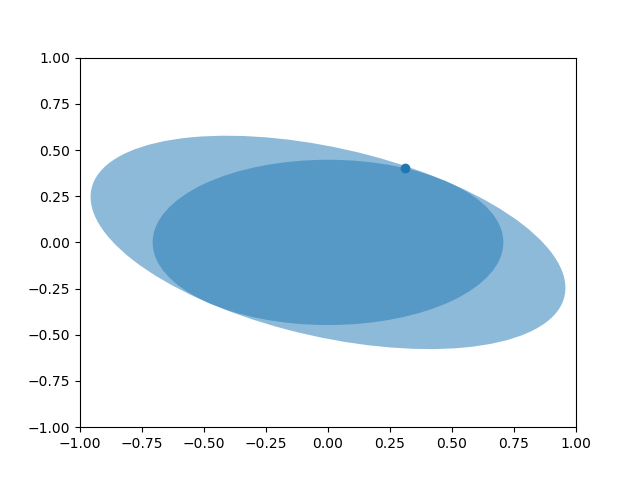

point of contact for the h Ellipsoid [0.3091480 0.4022077]


(-1, 1)

In [10]:
%matplotlib notebook

# BARE MINIMUM TEST
# #This is the 2d case with ellipses: I expect a non-trivial λ here
big = inst(2,2)
δ=np.arccos(np.sqrt(1.0/3)) + 0.3 #+ 0.44 #0.43 #0.45 #43  #0.44, 250; 0.4402, 410; 0.4403 610; 0.44038
print("δ is",δ)
θ=-np.arcsin(1/3.0) #-0.01 #- 0.5
big.gEl.X = np.array([[1.0,0],[0,4]])
big.gEl.v = np.array([np.cos(δ),np.sin(δ)])
big.hEl.X = np.array([[2.0,0],[0,5]]) # * 0.8 #* 3 #1
big.hEl.v = np.array([np.cos(δ+θ),np.sin(δ+θ)])

print(big.gEl.v)

print(big.hEl.v)

# big = inst(3,3)
# big.hEl.X = np.array([[4.0,0,0],[0,50000,0],[0,0,6000]])
# big.hEl.v = np.array([1.0,0.5,0])
# big.gEl.X = np.array([[1.0,0,0],[0,3,0],[0,0,4]])
# big.gEl.v = np.array([1.0,1.0,1])

# SPLIT TEST
# This shows a split (remove the -0.01 to get a tight value)
# for adjusting the graph you may want to fix the range
# big = inst(4,4)
# big.hEl.X = np.array([[1.0,0,0,0],[0,2,0,0],[0,0,6,0],[0,0,0,7]])
# big.hEl.v = np.array([1.0,1.0,0.0,0.0])/np.sqrt(2.0)
# big.gEl.X = np.array([[4.0/3.0 - 0.01,0,0,0],[0,2,0,0],[0,0,6,0],[0,0,0,7]])
# big.gEl.v = np.array([1.0,0.0,0,0])

plt.figure(0)
big.selfEval(debug=1,skipλ=True)
ax=plt.gca()
ax.set_ylim([-4E-3,4E-3])
ax.set_xlim([0,1])
# ax.set_ylim([0,1E-10])
# ax.set_xlim([0.99,1])


plt.figure(1)
hEll=Ellipse(xy=(0,0),width=2/big.hEl.X[0,0]**0.5, height=2/big.hEl.X[1,1]**0.5, angle=(0)*180/np.pi)
gEll=Ellipse(xy=(0,0),width=2/big.gEl.X[0,0]**0.5, height=2/big.gEl.X[1,1]**0.5, angle=θ* 180/np.pi)
hEll.set_alpha(0.5)
gEll.set_alpha(0.5)
plt.scatter(big.hEl.c[0],big.hEl.c[1]) #this needs to be changed because cs are evaulated for Xps and not Xs
print("point of contact for the h Ellipsoid", big.hEl.c)
ax = plt.gca()
ax.add_artist(hEll)
ax.add_artist(gEll)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

In [ ]:
plt.figure(0)
ax = plt.gca()
ax.set_ylim([0,1E-1])#0.000020])


In [6]:
#Indexing starts from zero so that concatenation is natural
class inst:
    #λ_c = 100000 #put some large number (this is for the split like monotone family)
    #I am using the merge like monotone family for which I must use λ_c = 0
    λ_c = 0
    λ_cut = 0.9999
    #λ_cut = 0.99999999 #1.0 #np.pi/2 #1000 #10000
    
    #fSize is supposed to be the total number of axis in the big ellipsoid (the main problem)
    #size is supposed to be the number of axis in the current ellipsoid    
    def __init__(s,fSize,size):
        s.fSize = fSize
        s.size = size
        
        #The first parameter is full sized because these guys themeselves are expressed in the standard basis
        s.basisT = np.zeros((fSize,size)) 
                
        #This is the normal basis vector. Nothing would be along this direction but it would be needed for defining 
        #the honest state etc.
        s.basisN = np.zeros(fSize) 
        
        #The sign value which must be plus minus one (see the description of the algorithm in the report for details)
        s.sgn = 1
        
        #The sign for the sub problem
        s.sgnSub = 1
                
        #The g ellipsoid
        s.gEl = ellipsoid(size)
        
        #The h ellipsoid
        s.hEl = ellipsoid(size)
        
        #The n-unitary
        s.nU = np.eye(size)
        
        #This should be one when the system can't solve further
        s.over = 0
        
        #λ that minimizes (found internally)
        s.λ_min = inst.λ_c
    def __str__(s):
        print("Instance properties\n") # of size ",s.size," with global size ",s.fSize,".\n")
        print("basisN\n",s.basisN)
        print("basisT\n",s.basisT)
        print("Sign now is ",s.sgn, " and for the subproblem ",s.sgnSub)
        print("The n-unitary is \n",s.nU)
        print("g-",s.gEl)
        print("h-",s.hEl)
        print("over ",s.over)        
        return " "
    #Now that the number of parameters is growing out of control, here's a description
    # skipλ = True/False (if True, it uses manλ as the value for λ; if False, it searches for λ in the lookIn interval)
    # special2d = -1/1/0 | -1,1 basically implement a 2x2 move by sending the initial state to the final state as a reflection/rotation
    #                    | 0 to implement the usual algorithm by finding a minima
    # tighten = True/False | This will/will not try to tighten the move by expanding the h-ellipsoid; it will look in the lookIn bracket; it can be made to look at the full interval by setting countIn>1
    # wiggleV = True/False | True means the system will try to handle infinities in a clever way (works only at level 1)
    # countIn = 1 | higher numbers will force the tighten method to look at the full interval between (0,1)
    # τscale = 1.0 | this scales the τd graph for convenience in viewing
    # gRes = 0.00005 | resolution of the graph that is plotted
    def selfEval(s,debug=0,skipλ=False,manλ=0,special2d=0,tighten=True,\
                 wiggleV=False,lookIn=(0.0,1.0),τscale=1.0,countIn=1,\
                gRes=0.0001,gResIn=(-0.1,0.1)):

        if(1):#(s.gEl.v > 1E-15).any()  and (s.hEl.v > 1E-15).any()):
        
            s.gEl.normPosVec()
            s.hEl.normPosVec()
            
            s.lookIn = lookIn
            s.countIn = countIn
            print("f(0) and f(1) are ",s.minL(0),s.minL(1))
                                            
            #This should find the scaling which makes the ellipsoids touch
            if(tighten == True and (s.minL(1)>0 or s.minL(0)>0)):            
                root = brenth(s.minL,0,1)
                s.hscaling = root
                print("Best scaling",s.hscaling)
                print("Value at best scaling",s.minL(s.hscaling))
            elif(tighten==True):
                s.hscaling = 1.0
                print("Looks like it's already tight")

            #This should find λ_min for the right scaling
            #res = minimize_scalar(s.L,bounds=s.lookIn,method='bounded')#,tol=1E-14) #(0,inst.λ_cut),method='bounded')
            res = minimize_scalar(s.τd,bounds=s.lookIn,method='bounded',options={'xatol': 1e-14, 'maxiter': 1000, 'disp': 0})
            #resλ=0.0
            #s.minL(s.hscaling,resλ)


            #Plots the operator monotone magic before proceeding
            #s.hscaling=1.0
            #x=np.arange(-1,1.0,gRes)
            
            #This allows one to get higher resolution in a given interval
            #Else the whole thing becomes sluggish
            xLeft=np.arange(-1,gResIn[0],0.001)
            xIn = np.arange(gResIn[0],gResIn[1],gRes)
            xRight = np.arange(gResIn[1],1,0.001)
            #x1=np.arange(0,1,0.00005)
            #x2=np.arange(-1,0,0.00005)
            x = np.concatenate((xLeft,xIn,xRight))
            i=0
            y=x*0
            y2=x*0
            for x_ in x:
                y[i]=s.L(x_) #np.log(1+s.L(x_))
                y2[i]= τscale * s.τd(x_) #4E7
                i=i+1

            #y=s.L(x)
            plt.plot(x,y,'r-') #label=str(s.size))
            plt.plot(x,y2,'b-')
            

            
            ax = plt.gca()
            #ax.set_xlim([xmin,xmax])
            #ax.set_ylim([0,1E-4]) #0.000020])
            ax.grid(color='r', linestyle='-', linewidth=0.5)

            #Operator monotone magic's here
            #if(s.L(0)< 1E-15 or skipλ==True):
            if( skipλ==True):
                #s.hEl.Xp = s.hEl.X *s.hscaling # hscaling should be irrelevant;
                #s.gEl.Xp = s.gEl.X
                #s.sgnSub = s.sgn #the sub problem (see below) has the same sign as the current sign
                #s.λ_min = 0 #manλ #0.0 #inst.λ_c
                s.λ_min = manλ #[0]  add this for the basinhop
                for i in range(0,s.hEl.Size):
                    s.hEl.Xp[i,i] = inst.f(s.λ_min, s.hEl.X[i,i] *s.hscaling) #1 /(s.λ_min + s.hEl.X[i,i])
                    s.gEl.Xp[i,i] = inst.f(s.λ_min, s.gEl.X[i,i]) #1/(s.λ_min + s.gEl.X[i,i])
                s.sgnSub=s.sgn #the sub problem (to be evaluated in the next step) has a flipped sign if a certain op mon family is used                
            else:
                s.λ_min = res.x #[0]  add this for the basinhop
                for i in range(0,s.hEl.Size):
                    s.hEl.Xp[i,i] = inst.f(s.λ_min, s.hEl.X[i,i] *s.hscaling) #1 /(s.λ_min + s.hEl.X[i,i])
                    s.gEl.Xp[i,i] = inst.f(s.λ_min, s.gEl.X[i,i]) #1/(s.λ_min + s.gEl.X[i,i])
                s.sgnSub=s.sgn #the sub problem (to be evaluated in the next step) has a flipped sign if a certain op mon family is used
            if(debug):
                print("λ optimisation result\n",res.x)
                print("λ_min",s.λ_min)

            #Now that the primed ellipsoids are known, go ahead and find the tangents and curvatures for them
            #to specify the sub problem
####################
            messup=False
            
            if(messup):
                s.gEl.selfEval()#conv=False)
                s.hEl.selfEval(conv=False)#conv=False)
            else:
                s.gEl.selfEval()
                s.hEl.selfEval()
                
            
            if(debug):
                print("Before Wiggle-v")
                print("v is ",s.gEl.v)
                print("w is ",s.hEl.v)
                print("X-h",s.hEl.X)
                print("X_g",s.gEl.X)
                #print("The h-normal/tangent is \n",s.hEl.nt)
                #print("The g-normal/tangent is \n",s.gEl.nt)
            #Code to specify nU in the basisT
            #Let us handle the base case first
            if(special2d!=0 and s.size==2):
                v=s.gEl.v
                w=s.hEl.v
                v=v/np.sqrt(v.dot(v))
                w=w/np.sqrt(w.dot(w))
                
                vperp = np.zeros(2)
                vperp[0],vperp[1]=v[1],-v[0]
                wperp = np.zeros(2)
                wperp[0],wperp[1]=w[1],-w[0]
                
                s.nU = np.outer(w,v.T) - special2d*np.outer(wperp,vperp.T)
                print("sub-Unitary\n",s.nU)
                print("it's square\n",s.nU.dot(s.nU.T))
                
                eigval,eigvec = linalg.eig(s.nU)
                print("eigval\n", eigval)
            #This is the iterable case
            else:
                #We must handle the padding (the g-padding can be supressed I think by adding a constant)
                #The limits behave non-trivially here
                print("gpar is ", gPar.xmax)
                print("hX is \n", s.hEl.X)
                print("hX.any >= gPar.xmax/10.0 ?", (s.hEl.X >= gPar.xmax/10.0 ).any())
                #(gPar.xmax/100.0)

                #t_h'
                thp = np.copy(s.hEl.nt[:,1]) #This should pick up the tangent pointing along the padded direction
                #n_h'
                nhp = np.copy(s.hEl.n) #This should copy the normal evaluated at the point of contact

                #cosθ
                gnv = s.gEl.n.dot(s.gEl.v)
                hnv = s.hEl.n.dot(s.hEl.v)
                τ =  gnv / hnv 
                if(debug):
                    print("gnv/hnv=",gnv,"/",hnv)
                    print("= τ = ",τ)


                if(wiggleV==True and (s.hEl.X >= gPar.xmax/10.0  ).any() ):
                    print("Implementing Wiggle-v")
                    #To start with I consider only one padding in the hEllipsoid
                    #This solution is based on the Wiggle-v method
                    
                    print("this is the tangent I picked: ", thp)
                    if(np.abs(τ) < 1 ):
                    #If this step fails... well then you need to reconsider some of the basic assumptions behind the scheme; 
                        θ = np.arccos( τ ) #This is an approximation which gets better with xmax larger
                    
                        #nh: the corrected normal
                        nh = np.cos(θ) * nhp + np.sin(θ) * thp

                        #th: the corrected tangent
                        th = np.sin(θ) * nhp - np.cos(θ) * thp                        
                        
                        #this is to fix the direction of the tangent according to the convention
                        sgn=np.sign(s.hEl.v.dot(th))
                        th = sgn*th
                        
                        #update the normal for the hEl
                        s.hEl.n = np.copy(nh)
                        s.hEl.nt[:,0]= np.copy(nh)
                        
                        #update the tangent
                        s.hEl.nt[:,1]=np.copy(th)
                        s.hEl.t[:,0]=np.copy(th)
                        
                        #the curvature along the old tangent was supposed to be infinite
                        #the curvature along the new tangent should also be infinite
                        #thus we need to change nothing more
                        
                        #This is no longer needed as we change the tangent by hand
                        #Update the curvature calculations using the newly found normal instead of the contact point
                        #s.hEl.selfEval(nGiven=True,conv=not messup)

                        if(debug):
                            print("After Wiggle-v")
                            print("The h-normal/tangent is \n",s.hEl.nt)
                            #print("The g-normal/tangent is \n",s.gEl.nt)

                    else:
                        if(np.abs(τ)>1):
                            print("Wiggle-v can't be implemented")
                        else:
                            print("Wiggle-v is pointless at this stage")
                    
                    
                    
                s.nU = s.hEl.nt.dot(s.gEl.nt.T)
#                 else:
#                     #if wiggle-v was not invoked, we auto apply the scaling
#                     s.nU = s.hEl.t.dot(s.gEl.t.T)
#                     s.nU += s.hEl.nt[:,0].dot(s.gEl.n[:,0].T)
                    
                #print("glaba this won't print!")
            if(debug):
                print("nU\n",s.nU)
                #print("hX is ", s.hEl.X)
            #For size = 2 give an explicit solution
            s.over=0
        else:
            s.over=1
    def λscale(λ):
        #return np.log(1/(1 - λ**1.1 )) ## <good
        #np.tan(λ) ## <also good but change the range of λ when the time comes
        return np.tan(λ*np.pi/2)
        #return 1.0E3 * λ**0.5
    def f(λ,x):
        #return ( np.exp(1+λ**(0.5)) )*x/(1.0+ ((λ+1) **2 -1 )*x)
        #return ( np.exp(1+λ**(0.5)) )*x/(1.0+ λ*x)
        #return (1+np.tan(λ))*x/(1.0+ (np.tan(λ)) *x)
        
        
        #return (1+inst.λscale(λ))*x/(1.0+ (inst.λscale(λ)) *x) ## < good
        λ=inst.λscale(λ)
        #return -(1+λ)/(λ + x)
        return (1+np.abs(λ))*x/(1+λ*x)
    def fb(λ,x):
        return -(x/(1.0+λ*x))**2
    def fbPrime(λ,x):
        return (x/(1.0+λ*x))**3
    def fbPrime2(λ,x):
        return -(x/(1.0+λ*x))**4

    def τd(s,λ,func=f,debug=0):
        #Evaluates f_λ(X_h) and f_λ(X_g)
        for i in range(0,s.hEl.Size):            
            s.hEl.Xp[i,i] = func(λ,s.hscaling*s.hEl.X[i,i]) #(np.exp(λ*0))*s.hEl.X[i,i]/(1 + (np.exp(λ) - 1) *s.hEl.X[i,i])
            s.gEl.Xp[i,i] = func(λ,s.gEl.X[i,i]) #(np.exp(λ*0))*s.gEl.X[i,i]/(1 + (np.exp(λ) - 1) *s.gEl.X[i,i])
            
            
            #s.hEl.Xp[i,i] = -1/(λ + s.hEl.X[i,i])
            #s.gEl.Xp[i,i] = -1/(λ + s.gEl.X[i,i])

            #s.hEl.Xp[i,i] = -s.hEl.X[i,i]/(λ + s.hEl.X[i,i])
            #s.gEl.Xp[i,i] = -s.gEl.X[i,i]/(λ + s.gEl.X[i,i])
            
        wnh=s.hEl.v.dot(s.hEl.Xp).dot(s.hEl.v) / s.hEl.v.dot(s.hEl.Xp.dot(s.hEl.Xp)).dot(s.hEl.v)
        vng=s.gEl.v.dot(s.gEl.Xp).dot(s.gEl.v) / s.gEl.v.dot(s.gEl.Xp.dot(s.gEl.Xp)).dot(s.gEl.v)
        τd=np.abs(wnh - vng)
        #L = s.sgn * (s.hEl.v.dot(s.hEl.Xp).dot(s.hEl.v)  -  s.gEl.v.dot(s.gEl.Xp).dot(s.gEl.v))      
        #L = (s.hEl.v.dot(s.hEl.Xp).dot(s.hEl.v)/s.gEl.v.dot(s.gEl.Xp).dot(s.gEl.v)) ** (-s.sgn)
        #L = (s.hEl.v.dot(s.hEl.Xp).dot(s.hEl.v)/s.gEl.v.dot(s.gEl.Xp).dot(s.gEl.v)) ** (-s.sgn)
        if(debug==1):
            print("ellipsoid h primed\n", s.hEl.Xp)
            print("ellipsoid g primed\n", s.gEl.Xp)
            print("L",L)
        #Evaluates L(λ)
        return τd
    
    
    def L(s,λ,func=f,debug=0):
        #Evaluates f_λ(X_h) and f_λ(X_g)
        for i in range(0,s.hEl.Size):            
            s.hEl.Xp[i,i] = func(λ,s.hscaling*s.hEl.X[i,i]) #(np.exp(λ*0))*s.hEl.X[i,i]/(1 + (np.exp(λ) - 1) *s.hEl.X[i,i])
            s.gEl.Xp[i,i] = func(λ,s.gEl.X[i,i]) #(np.exp(λ*0))*s.gEl.X[i,i]/(1 + (np.exp(λ) - 1) *s.gEl.X[i,i])
            
            
            #s.hEl.Xp[i,i] = -1/(λ + s.hEl.X[i,i])
            #s.gEl.Xp[i,i] = -1/(λ + s.gEl.X[i,i])

            #s.hEl.Xp[i,i] = -s.hEl.X[i,i]/(λ + s.hEl.X[i,i])
            #s.gEl.Xp[i,i] = -s.gEl.X[i,i]/(λ + s.gEl.X[i,i])
            

        L = s.sgn * (s.hEl.v.dot(s.hEl.Xp).dot(s.hEl.v)  -  s.gEl.v.dot(s.gEl.Xp).dot(s.gEl.v))        
        #L = (s.hEl.v.dot(s.hEl.Xp).dot(s.hEl.v)/s.gEl.v.dot(s.gEl.Xp).dot(s.gEl.v)) ** (-s.sgn)
        #L = (s.hEl.v.dot(s.hEl.Xp).dot(s.hEl.v)/s.gEl.v.dot(s.gEl.Xp).dot(s.gEl.v)) ** (-s.sgn)
        if(debug==1):
            print("ellipsoid h primed\n", s.hEl.Xp)
            print("ellipsoid g primed\n", s.gEl.Xp)
            print("L",L)
        #Evaluates L(λ)
        return L
    def minL(s,hscaling,resλ=0):
        s.hscaling=hscaling
        res = [minimize_scalar(s.L,bounds=s.lookIn,method='bounded'),\
                minimize_scalar(s.L,bounds=(0,inst.λ_cut),method='bounded'),\
                minimize_scalar(s.L,bounds=(0,0.1),method='bounded'),\
                minimize_scalar(s.L,bounds=(0.1,0.4),method='bounded') ]
        resλ = res[np.argmin([s.L(res[i].x) for i in range(1)])].x
        
        return min(s.L(resλ),s.L(0)) #+ 1E-14
#         #resλ = res[np.argmin(s.L(res))]
#         #print("resλ",λ)
#         #return s.L(resλ) 
#         res0 = minimize_scalar(s.L,bounds=(0,inst.λ_cut),method='bounded')
#         res1 = minimize_scalar(s.L,bounds=(0,0.1),method='bounded')
#         res2 = minimize_scalar(s.L,bounds=(0.1,0.4),method='bounded')

#         return min(s.L(res2.x),s.L(res1.x),s.L(res0.x),s.L(0)) #+ 1E-12  #to suppress false negatives due to numerical errors

    def Ldummy(s,λ):
        return 0.0
    

### The Iteration Step


In [7]:
#I take as input the previous instance and return the next instance
def GoSmall(big, small, par): #debug=0,skipλ=False,manλ=0,special2d=0,wiggleV=False,tighten=True,lookIn=(0.0,1.0)):
    if(big.over==0):        
        #I assume that big is completely specified and I need to find small
        #I also assume that small has been initialised to zeros of the right size


        #Task
        #small.basisT = big.hEllipsoid.t converted to the standard basis from big.basisT
        #small.basisN = big.hEllipsoid.n converted to the standard basis from big.basisT (and not big.basisN because the ellipsoids are in the big.basisT space)

        #Solution
        # let m= size of a vector t_h in basisT
        # let n= size of vector in basisT in the standard basis
        # hEl.t = mx(m-1)
        # basisT = nxm matrix (n rows to specify in the standard basis each vector in basisT)
        # basisT * basisT.T = nxm * mxn matrix = nxn matrix
        # basisT * hEl.t = nxm * mx(m-1) matrix = nx(m-1) matrix  <<I am using this one
        # 
        small.basisT = big.basisT.dot(big.hEl.t)         
        small.basisN = big.basisT.dot(big.hEl.n)        
        small.sgn = big.sgnSub

        small.gEl.X = big.gEl.Xc
        small.hEl.X = big.hEl.Xc


        #Task
        #small.hEllipsoid.v = [big.hEllipsoid.v - small.basisN.dot(big.hEllipsoid.v) small.basisN] converted from big.basisT to small.basisT 
        #small.gEllipsoid.v = ... the appropriate thing with nU being used

        #Solution
        # NB: even though this would produce an unormalised vector that's fine because internally it will get normalised
        # hEl.t = mx(m-1)
        # hEl.v = m
        # hEl.t.T * hEl.v = (m-1)xm * m = (m-1) <<This will work because it is automatically neglecting the component along the normal
        small.hEl.v = big.hEl.t.T.dot(big.hEl.v)
        small.gEl.v = big.hEl.t.T.dot(big.nU.dot(big.gEl.v)) #note I have to use the hEl.t basis for both because the unitary converts things to make the ellipsoids easier to describe
        
        #If at this point hEl.v and gEl.v are zero then we are through (this is checked in selfEval automatically)
        
        #if(eva==1):
        small.selfEval(**par) #debug=debug,skipλ=skipλ,manλ=manλ,special2d=special2d,wiggleV=wiggleV,tighten=tighten,lookIn=lookIn)
        
        return 0
    else:
        print("can't solve futher.")
        return 1

In [ ]:
#TEST
big = inst(4,4)
small = inst(4,3)
smaller = inst(4,2)

big.basisT = np.eye(4) #np.array([[0,1.0,0,0],[0,0,1.0,0],[0,0,0,1.0]]).T
big.basisN = np.array([0.0,0,0,0])
big.hEl.X = np.array([[10.0,0,0,0],[0,10,0,0],[0,0,10,0],[0,0,0,10]])
big.hEl.v = np.array([1.0,1.0,1.0,0.0])/np.sqrt(3.0)
big.gEl.X = np.array([[5.0,0,0,0],[0,5,0,0],[0,0,5,0],[0,0,0,5]])
big.gEl.v = np.array([1.0,0.0,0,0])

big.selfEval()
GoSmall(big,small,1)
GoSmall(small,smaller,1)



plt.show()

In [ ]:
#small.selfEval()
#big.hEl.t.T.dot(big.nU.dot(big.gEl.v))
print(big)
print(small)
print(smaller)

In [ ]:
small.selfEval()
print(small)

In [ ]:
x=np.arange(1,20,0.1)
y=np.cos(x)
y2=y*x
plt.plot(x,y)
plt.plot(x,y2)
plt.show()

### Finding the Unitary

Hopefully the last recursion step.

In [8]:
class unitarySolver:
    def __init__(s,fSize,size):
        s.fSize = fSize
        s.size = size
        s.base = inst(fSize,size)
    #At the root level, it will by default apply wiggleV; for the iteration step it won't 
    def selfEval(s,par): #debug=0,skipλ=False,wiggleV=True,special2d=0,tighten=True,manλ=0,lookIn=(0.0,1.0)):
        s.base.selfEval(**par) #debug=debug,skipλ=skipλ,wiggleV=wiggleV,special2d=special2d,tighten=tighten,manλ=manλ,lookIn=lookIn)        
        s.instances = [s.base]
        s.size -=1
        s.instances.insert(0,inst(s.fSize,s.size))
        
    def iterate(s,par): #debug=0,skipλ=False,manλ=0,special2d=0,wiggleV=False,tighten=True,lookIn=(0.0,1.0)): #This will apply the iteration step
        if(s.size<2):
            if(debug):
                print("Reached size 2; can't go smaller.")
            return
        else:
            if(GoSmall(s.instances[1],s.instances[0],par) == 0): #debug,skipλ,manλ,special2d,wiggleV,tighten,lookIn) == 0):
                s.size -= 1
                s.instances.insert(0,inst(s.fSize,s.size))
            else:
                print("Solution found.")

    def getU(s,debug=0): #will output the unitary using the sub-unitaries evaluated so far
        rB = s.instances[1] #s.base #s.instances[0]
        U = rB.basisT.dot(rB.nU).dot(rB.basisT.T)        
        for i in range (2,len(s.instances)):
            if(debug):
                print(i)
            rBp = s.instances[i-1]
            rB = s.instances[i]
            U = (np.outer(rBp.basisN,rBp.basisN) + U).dot(rB.basisT.dot(rB.nU.dot(rB.basisT.T)))
        return U

### 4x4 Mochon's Denominator

Don't forget to change the parameter in the legacy code before trying to run this

<IPython.core.display.Javascript object>


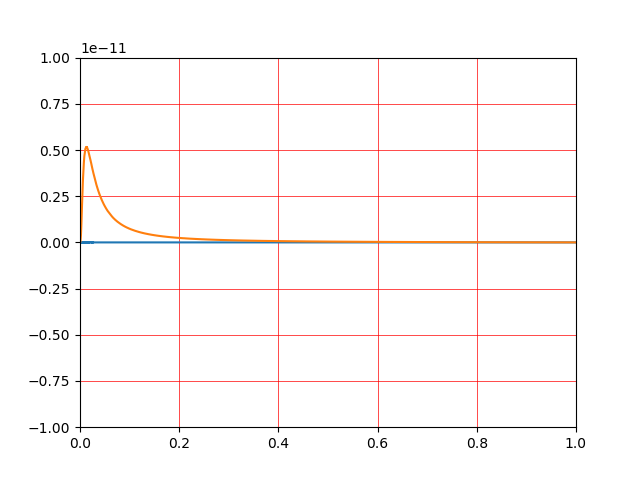

f(0) and f(1) are  -100.0 -1.7763568394e-15
Looks like it's already tight
λ optimisation result
 0.814635105614
λ_min 0
Before Wiggle-v
v is  [0.1690309 0.6324555 0.6324555 0.4140393]
w is  [0.4140393 0.6324555 0.6324555 0.1690309]
X-h [[99.4000000 0.0000000 0.0000000 0.0000000]
 [0.0000000 99.8000000 0.0000000 0.0000000]
 [0.0000000 0.0000000 100.4000000 0.0000000]
 [0.0000000 0.0000000 0.0000000 100.8000000]]
X_g [[99.2000000 0.0000000 0.0000000 0.0000000]
 [0.0000000 99.6000000 0.0000000 0.0000000]
 [0.0000000 0.0000000 100.2000000 0.0000000]
 [0.0000000 0.0000000 0.0000000 100.6000000]]
gpar is  100000.0
hX is 
 [[99.4000000 0.0000000 0.0000000 0.0000000]
 [0.0000000 99.8000000 0.0000000 0.0000000]
 [0.0000000 0.0000000 100.4000000 0.0000000]
 [0.0000000 0.0000000 0.0000000 100.8000000]]
hX.any >= gPar.xmax/10.0 ? False
gnv/hnv= 0.999992000096 / 0.999992000096
= τ =  1.0
nU
 [[0.9605818 0.2483785 0.0955083 0.0804288]
 [-0.2609032 0.9593940 0.0485809 0.0955644]
 [-0.0909343 -0.09830

<IPython.core.display.Javascript object>


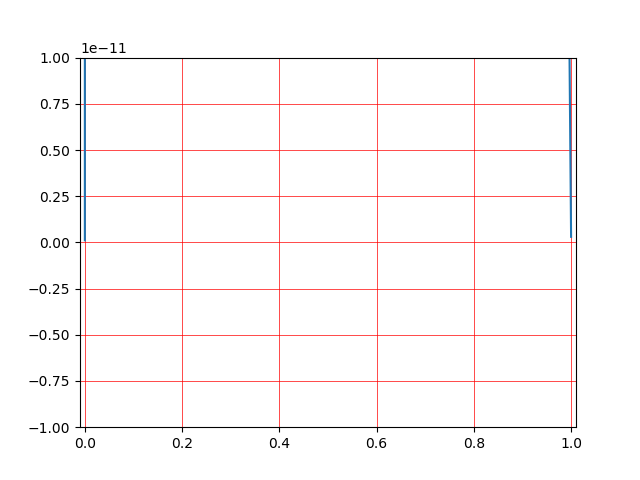

f(0) and f(1) are  -99.997599952 1.11022302463e-14
Best scaling 1.0
Value at best scaling 1.11022302463e-14
λ optimisation result
 0.999996349287
λ_min 0
Before Wiggle-v
v is  [0.8294637 0.5585606]
w is  [0.5568178 0.8306346]
X-h [[100.7284023 0.0000000]
 [0.0000000 99.6691977]]
X_g [[100.3274951 0.0000000]
 [0.0000000 99.2701048]]
sub-Unitary
 [[0.9258200 -0.3779648]
 [0.3779648 0.9258200]]
it's square
 [[1.0000000 0.0000000]
 [0.0000000 1.0000000]]
eigval
 [ 0.92581999+0.37796475j  0.92581999-0.37796475j]
nU
 [[0.9258200 -0.3779648]
 [0.3779648 0.9258200]]


 For a 4x4 Mochon's untrucated ladder rung transition (without axis points)

The Xh matrix: 
 [[99.4000000 0.0000000 0.0000000 0.0000000]
 [0.0000000 99.8000000 0.0000000 0.0000000]
 [0.0000000 0.0000000 100.4000000 0.0000000]
 [0.0000000 0.0000000 0.0000000 100.8000000]]
The Xg matrix: 
 [[99.2000000 0.0000000 0.0000000 0.0000000]
 [0.0000000 99.6000000 0.0000000 0.0000000]
 [0.0000000 0.0000000 100.2000000 0.0000000]
 [0.000000

In [12]:
%matplotlib notebook

####THE 4x4 CASE (even the assymetric situtation seems to work) ####


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

fSize = 4
size = 4
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)
uS.base.hEl.X = hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.v = sqph[1:]
uS.base.gEl.X = gDiag[1:,1:]
uS.base.gEl.v = sqpg[1:]



plt.figure(1)

uS.selfEval(1,skipλ=True)

uS.iterate(1,skipλ=True)

ax=plt.gca()
ax.set_ylim([-1E-11,1E-11])
ax.set_xlim([0,1])




plt.figure(2)

uS.iterate(1,skipλ=True,special2d=-1)

ax=plt.gca()
ax.set_ylim([-1E-11,1E-11])
ax.set_xlim([-0.01,1.01])
#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", U.dot(uS.base.gEl.v))

print("\n\n Solution\n")
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))
print("The final vector obtained:\n", uS.base.hEl.v)



D =  Xh - U.dot(Xg.dot(U.T))
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)


### The 6x6 Case

If there's no asymmetric function set skipλ to true. If there is, use skipλ true in the second step (the first step has too much numerical noise).

<IPython.core.display.Javascript object>


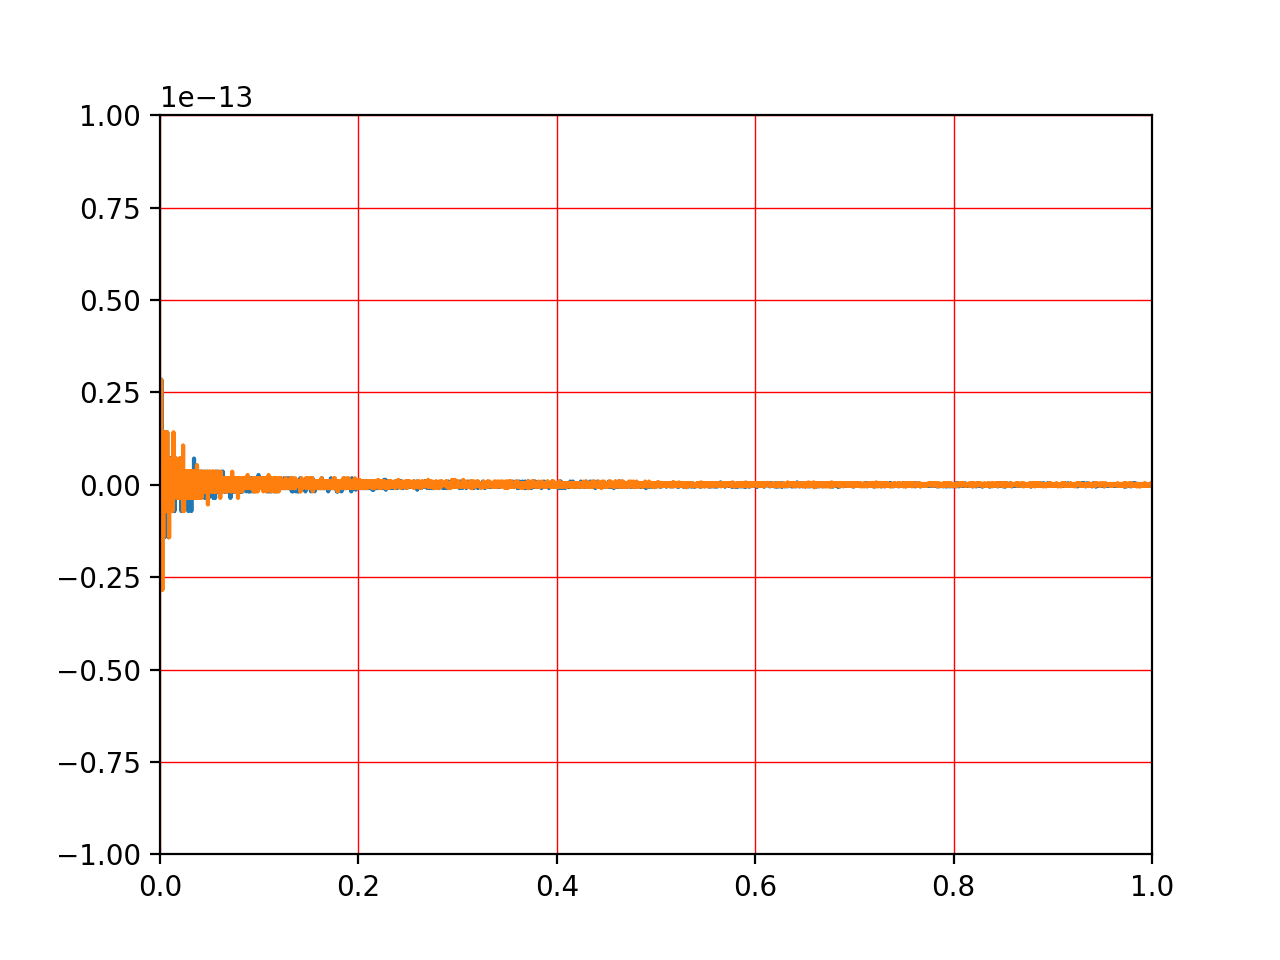

f(0) and f(1) are  -100.0 -2.22044604925e-16
Looks like it's already tight
λ optimisation result
      fun: -2.2204460492503131e-16
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.83162948039153917
λ_min 0
Before Wiggle-v
v is  [ 0.046524210519924  0.308606699924184  0.597614304667197
  0.534522483824849  0.487950036474267  0.147122471584125]
w is  [ 0.147122471584125  0.487950036474267  0.534522483824849
  0.597614304667197  0.308606699924184  0.046524210519924]
X-h [[  99.                   0.                   0.                   0.
     0.                   0.               ]
 [   0.                  99.400000000000006    0.                   0.
     0.                   0.               ]
 [   0.                   0.                  99.799999999999997    0.
     0.                   0.               ]
 [   0.                   0.                   0.                 100.400000000000006
     0.                   0.               ]
 [   0.          

<IPython.core.display.Javascript object>


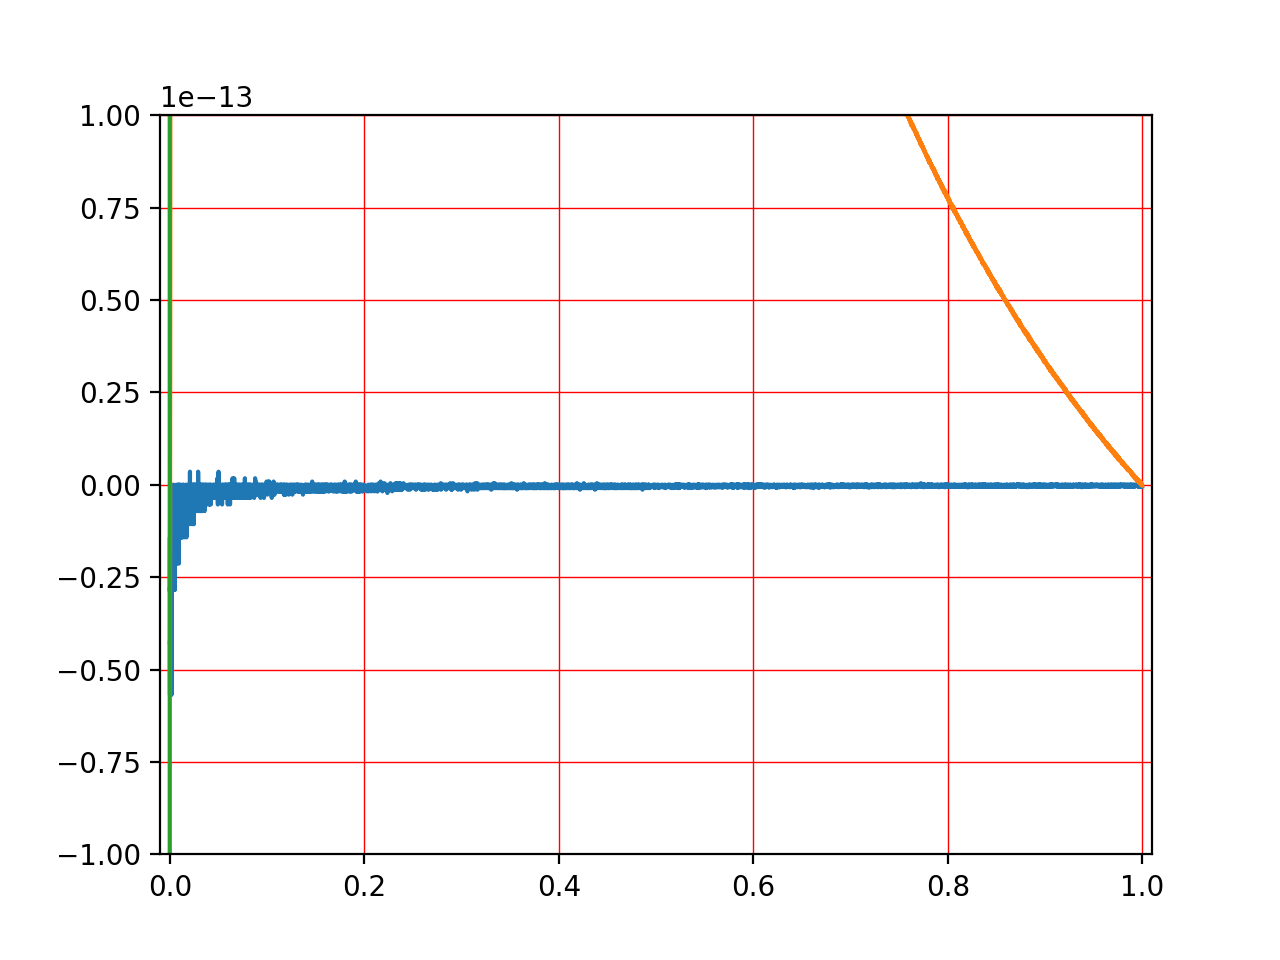

f(0) and f(1) are  -99.995999888 -2.84217094304e-14
Looks like it's already tight
λ optimisation result
      fun: -4.4408920985006262e-16
 message: 'Solution found.'
    nfev: 20
  status: 0
 success: True
       x: 0.60948156875178572
λ_min 0
Before Wiggle-v
v is  [ 0.430416824911163  0.629123066082992  0.613512995080062
  0.206270040053373]
w is  [ 0.204591208368242  0.611136377515559  0.629947635954423
  0.433382904013318]
X-h [[ 101.189262057212048    0.                   0.                   0.               ]
 [   0.                 100.622684793358005    0.                   0.               ]
 [   0.                   0.                  99.722674291708145    0.               ]
 [   0.                   0.                   0.                  99.061378745722834]]
X_g [[ 100.937128920640561    0.                   0.                   0.               ]
 [   0.                 100.274155066295123    0.                   0.               ]
 [   0.                   0.          

In [176]:
%matplotlib notebook

####THE 6x6 CASE####

#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 12

fSize = 6
size = 6
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)
uS.base.hEl.X = hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.v = sqph[1:]
uS.base.gEl.X = gDiag[1:,1:]
uS.base.gEl.v = sqpg[1:]



plt.figure(1)

uS.selfEval(1,skipλ=True)

uS.iterate(1,skipλ=True)

ax=plt.gca()
ax.set_ylim([-1E-13,1E-13])
ax.set_xlim([0,1])




plt.figure(2)

uS.iterate(1,skipλ=True) #,special2d=True)
uS.iterate(1,skipλ=True) #,special2d=True)
uS.iterate(1,skipλ=True,special2d=-1)

ax=plt.gca()
ax.set_ylim([-1E-13,1E-13])
ax.set_xlim([-0.01,1.01])
#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 6x6 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", U.dot(uS.base.gEl.v))

print("\n\n Solution\n")
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))
print("The final vector obtained:\n", uS.base.hEl.v)



D =  Xh - U.dot(Xg.dot(U.T))
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)


### The 14x14 case (oh yes!)

Also works now for the case of the truncation function $f(x)=1$ with ```skipλ``` set to ```True```. Had to also allow for changing the sign of the orthogonal vector in the ```special2D``` case.
I also checked the 10x10, and the 12x12 case.

It wasn't working earlier because the normal evaluated by the Weingarten map sometimes had a sign mistake due to numerical errors (the corresponding eigenvalue was never exactly zero, while analytically it should've been, so it is understandable)

<IPython.core.display.Javascript object>


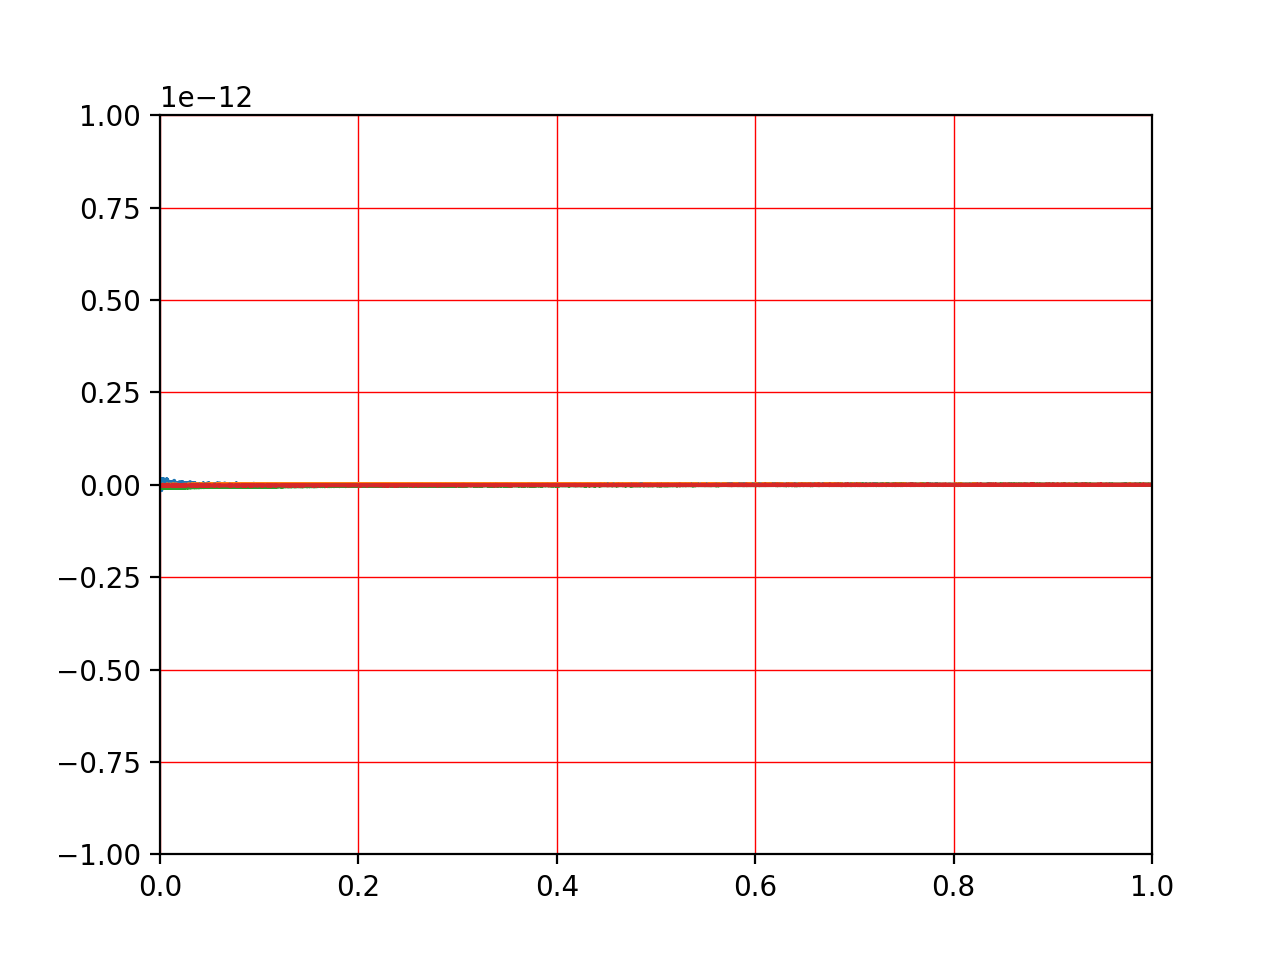

f(0) and f(1) are  -100.0 -1.44408920985e-15
Looks like it's already tight
λ optimisation result
      fun: -4.4408920985006262e-16
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.61814089024615992
λ_min 0.0
nU
 [[  9.99999539e-01   5.78585281e-05   1.22302909e-04   2.27014016e-04
    3.47074272e-04   3.92103202e-04   1.90283928e-04   4.93909851e-04
    4.45739755e-04   2.79109100e-04   1.28201351e-04   6.46354514e-05
    1.31173753e-05   1.26526901e-06]
 [ -6.57615602e-05   9.99964662e-01   1.93825760e-03   2.42837160e-03
    3.01240176e-03   2.87590471e-03   5.44714766e-04   4.64304452e-03
    3.84870588e-03   2.33882918e-03   1.07300919e-03   6.05479126e-04
    1.23613008e-04   1.19034995e-05]
 [ -1.56336981e-04  -2.24854750e-03   9.99223188e-01   1.70189814e-02
    1.38535072e-02   9.57142326e-03  -4.21993004e-03   2.29546522e-02
    1.72542216e-02   1.00988839e-02   4.62273910e-03   2.93413900e-03
    6.01035787e-04   5.76859265e-05]
 [ -3.10643863e

<IPython.core.display.Javascript object>


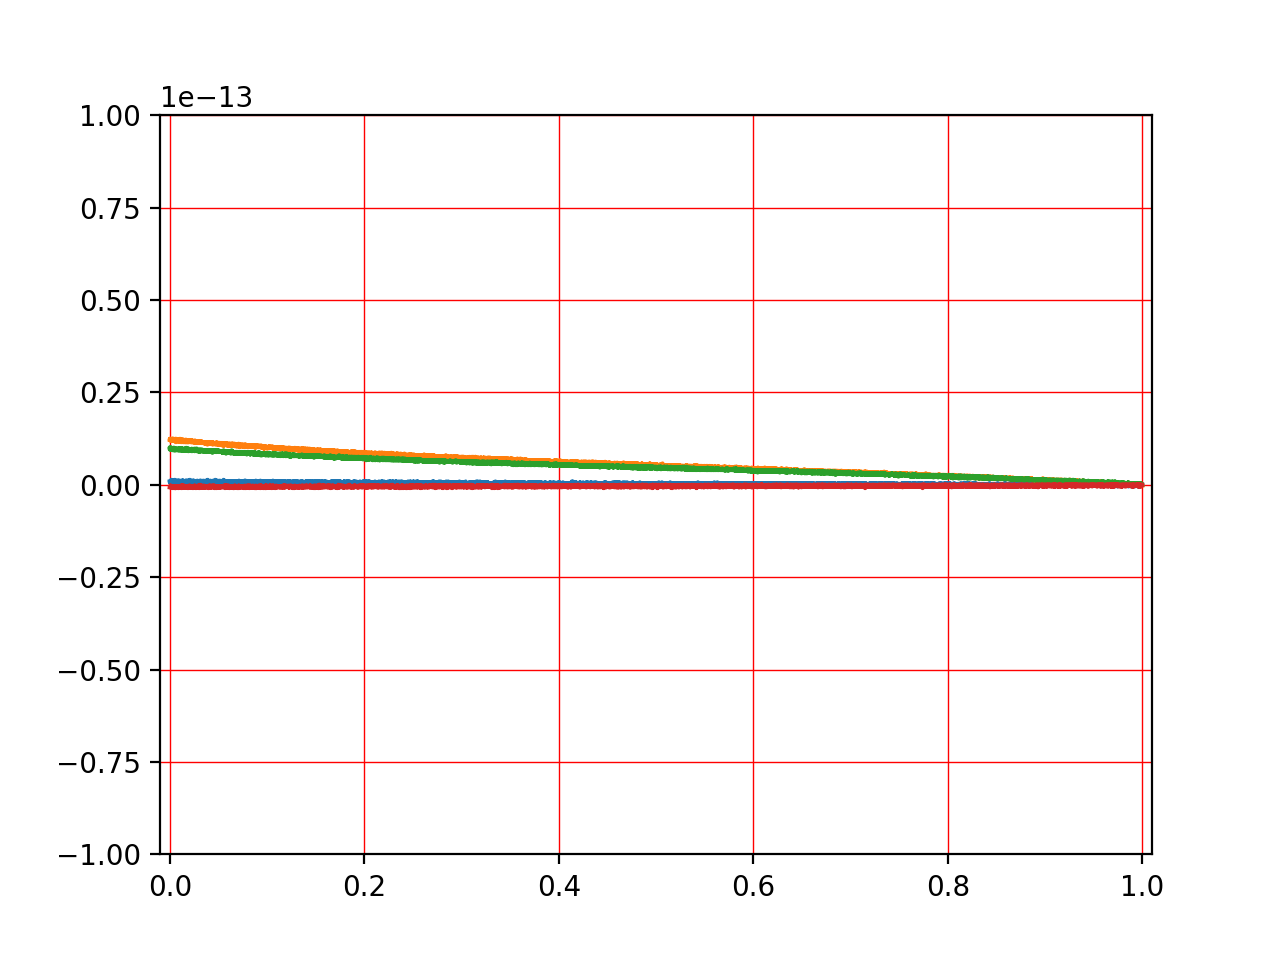

f(0) and f(1) are  -1.33334536239 -1e-15
Looks like it's already tight
λ optimisation result
      fun: 0.0
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.77475128974943286
λ_min 0.0
nU
 [[  9.97214538e-01   3.92796352e-02   3.51686815e-02   3.20610128e-02
   -2.46082857e-02  -2.37620817e-02  -1.97274499e-02  -1.29334622e-02
    5.36598034e-03  -2.94124345e-04]
 [  1.74136834e-02  -9.48988392e-01   1.66349294e-01   1.48537824e-01
   -1.22475442e-01  -1.25795660e-01  -1.09619325e-01  -7.43257871e-02
    3.18717072e-02  -9.56571340e-04]
 [  5.15413241e-03  -3.11277447e-02   7.95051244e-01  -3.43142734e-01
    2.74026112e-01   2.79880915e-01   2.47903870e-01   1.69790908e-01
   -7.37631783e-02   1.07585794e-03]
 [ -2.30911832e-02   1.13084348e-01   2.05083070e-01  -6.21218062e-01
   -4.42531563e-01  -4.01368018e-01  -3.59222766e-01  -2.46952397e-01
    1.08400409e-01   4.25641781e-04]
 [ -3.29395008e-02   1.46912117e-01   2.76811284e-01   3.19379218e-01
  

<IPython.core.display.Javascript object>


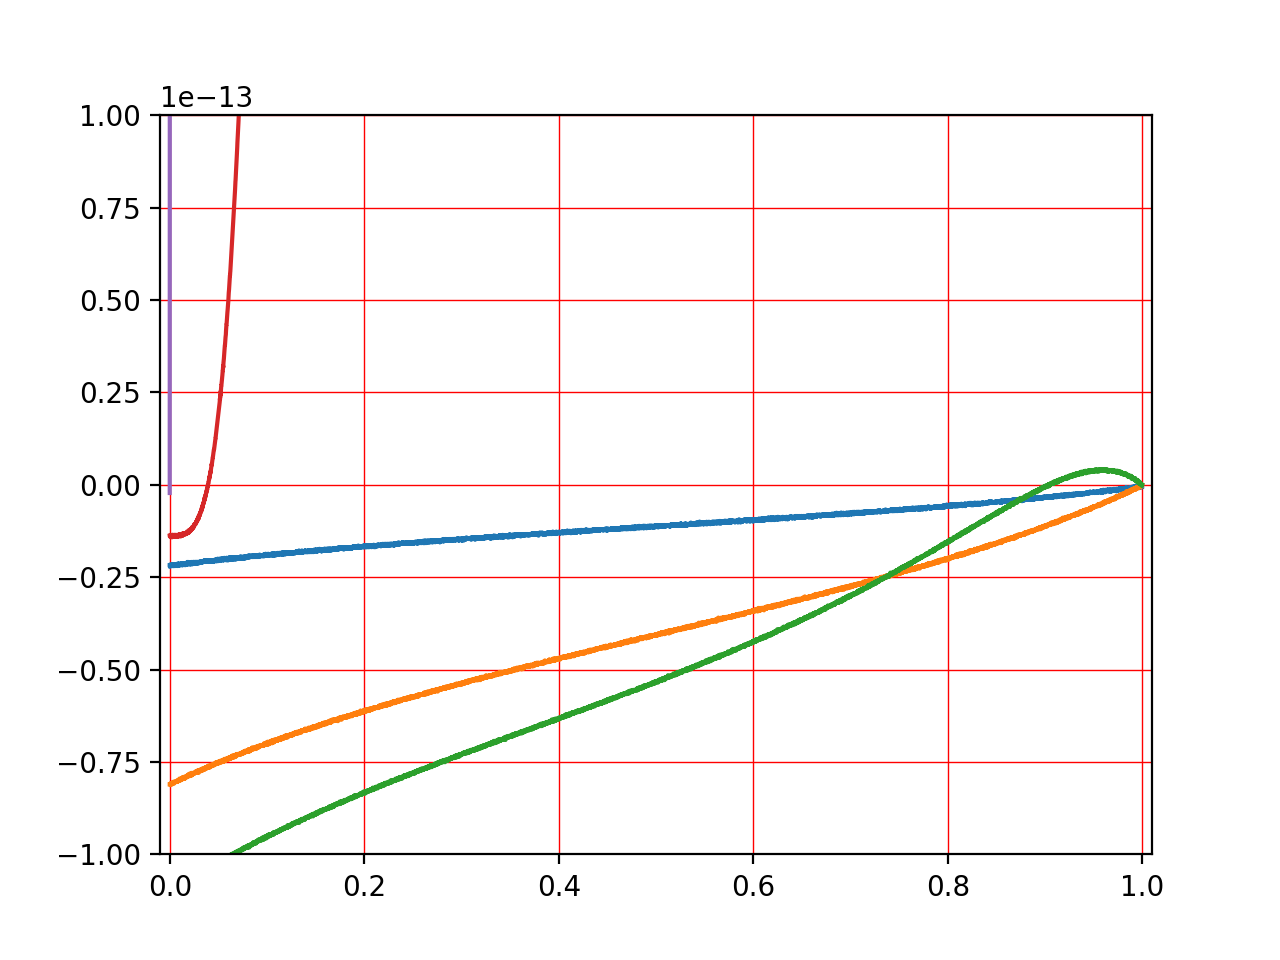

f(0) and f(1) are  -1.01797270023 -2.27603712827e-14
Looks like it's already tight
λ optimisation result
      fun: -2.1760371282653068e-14
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.0063398076490540859
λ_min 0.0
nU
 [[ 0.90843532 -0.36741936  0.11126039  0.1537487  -0.0600303   0.01127442]
 [ 0.32274198  0.83482853  0.40026733 -0.19545883  0.01801388  0.01250393]
 [-0.09259328  0.22394654  0.07779473  0.94525499 -0.20353238  0.01702913]
 [-0.21276044 -0.30969205  0.83672558  0.06652149  0.37502081 -0.11682645]
 [-0.11673294 -0.13231126  0.31889482 -0.19704249 -0.89806365 -0.14774705]
 [-0.05581924 -0.06705849  0.13982695 -0.03740775 -0.08653044  0.98180901]]
f(0) and f(1) are  -1.00876468384 -8.22683254026e-14
Looks like it's already tight
λ optimisation result
      fun: -8.1268325402561459e-14
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.0008393137647957731
λ_min 0.0
nU
 [[ 0.88670088 -0.31796092  0.31542424  0.

In [178]:
%matplotlib notebook

####THE 10x10 CASE####

#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 12

fSize = 14
size = 14
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)
uS.base.hEl.X = hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.v = sqph[1:]
uS.base.gEl.X = gDiag[1:,1:]
uS.base.gEl.v = sqpg[1:]



plt.figure(1)

uS.selfEval(1,skipλ=True)
uS.iterate(1,skipλ=True)
uS.iterate(1,skipλ=True)
uS.iterate(1,skipλ=True)

ax=plt.gca()
ax.set_ylim([-1E-12,1E-12])
ax.set_xlim([0,1])




plt.figure(2)

uS.iterate(1,skipλ=True) 
uS.iterate(1,skipλ=True) 
uS.iterate(1,skipλ=True) 
uS.iterate(1,skipλ=True)

ax=plt.gca()
ax.set_ylim([-1E-13,1E-13])
ax.set_xlim([-0.01,1.01])

plt.figure(3)

uS.iterate(1,skipλ=True) 
uS.iterate(1,skipλ=True) 
uS.iterate(1,skipλ=True) 
uS.iterate(1,skipλ=True) 
uS.iterate(1,skipλ=True,special2d=-1) #special2d 1 and -1 just flips the sign of the orthogonal vector
#uS.iterate(1,skipλ=True)

ax=plt.gca()
ax.set_ylim([-1E-13,1E-13])
ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 10x10 Mochon's untrucated ladder rung transition (without axis points)\n")
#print("The Xh matrix: \n",Xh)
#print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", uS.base.hEl.v)

print("\n\n Solution\n")
print("The Unitary (real):\n",U)
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))

print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))



D =  Xh - U.dot(Xg.dot(U.T))
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

base case
λ optimisation result
      fun: 0.0
 message: 'Solution found.'
    nfev: 24
  status: 0
 success: True
       x: 0.38634191759850478
λ_min 0.0
nU
 [[0.9609629 0.2469140 0.0954777 0.0804224]
 [-0.2594402 0.9597873 0.0485961 0.0955901]
 [-0.0910949 -0.0983116 0.9582061 0.2527401]
 [-0.0307052 -0.0904242 -0.2652611 0.9594359]]
iterating
λ optimisation result
      fun: 0.0
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.99998429426489566
λ_min 0.999984294265
nU
 [[0.9620141 -0.2659013 0.0618496]
 [0.2403181 0.9323163 0.2702471]
 [-0.1295224 -0.2451180 0.9608023]]
iterating
λ optimisation result
      fun: 0.0
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.99999360329087184
λ_min 0.999993603291
nU
 [[-0.9258800 -0.3778177]
 [0.3778177 -0.9258800]]
Honest state didn't match.
Size 3
1
2
[[-0.2799820 0.7856263 0.2617945 -0.4856594]
 [0.8552565 0.3999616 0.2000768 0.2617944]
 [-0.4275769 0.2000000 0.3999616 0.7856263]

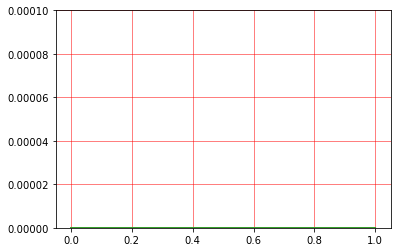

In [267]:
%matplotlib inline
#%matplotlib notebook

fSize=4
size=4


base = inst(fSize,size)


#This is from Mochon's construction
base.basisT = np.eye(size)
base.basisN = np.zeros(size)
base.hEl.X = hDiag[1:,1:] 
base.hEl.v = sqph[1:] 
base.gEl.X = gDiag[1:,1:] 
base.gEl.v = sqpg[1:] 

print("base case")
base.selfEval(debug=1,skipλ=True)



#GENERAL UNITARY
#The base case
rBase = [base]
size-=1
rBase.insert(0,inst(fSize,size))

print("iterating")
while (GoSmall(rBase[1],rBase[0],1,skipλ=False)==0):  #should be GoSmall == 0 and n>=2
    if(size>2): 
        print("iterating")
        size -= 1
        rBase.insert(0,inst(fSize,size))
    else:
        print("Honest state didn't match.")
        break
    

rB = rBase[0] #base
U = rB.basisT.dot(rB.nU).dot(rB.basisT.T)
    
print("Size", len(rBase))
i=1

for i in range(1,len(rBase)):
    print(i)
    rBp = rBase[i-1]
    rB = rBase[i]
    U = (np.outer(rBp.basisN,rBp.basisN) + U).dot(rB.basisT.dot(rB.nU.dot(rB.basisT.T)))
    
print(U)
print("This is probably not unitary either:\n", U.dot(U.T))
print("The final vector:", U.dot(base.gEl.v))
print("should be the same as:", base.hEl.v)


Xh = base.hEl.X
Xg = base.gEl.X

D = Xh - U.dot(Xg.dot(U.T))
eigenval,eigenvec = np.linalg.eigh(D)

print("Certificate (valid if all positive)",eigenval)


### 3 &rarr; 2 Main Ladder Move | Wiggle-v based

Using the Wiggle-V method, it seems to work well.

#### Some interesting observations
For ladder choice (n=2,pivot=100,Δ=0.4,xmax=1E10) I obtained

| 3-wiggle | 3-useλ | 2-useλ | 2-special2d | result | remarks |
| -- | -- | -- | -- |
| &check; | &cross; | &cross; | &check; | Works | Works for only one sign of special2d |
| &check; | &cross; | &check; | &cross; | Works! | This finds a non-trivial λ<sub>min</sub> after tightening and works :) |
| &cross; | &check; | &cross; | &check; | Fails | The honest state is wrong and the certificate invalid |

*Also Interesting*: In the last case though, τ (which was cosθ), seems to become 1 automatically.

Lattice
 [   0.                  99.200000000000003   99.599999999999994
  100.400000000000006  100.799999999999997] 
Prob
 [ -1.602048674253442e-02  -1.040907197580668e+06   2.080104116465873e+06
  -2.076682021912361e+06   1.037485119047642e+06]
Initial coordinates
 [[   0.                   0.                   0.               ]
 [   0.                  99.200000000000003    0.               ]
 [   0.                   0.                 100.400000000000006]] 
Initial prob
 [  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]
Final coordinates
 [[  9.959999999999999e+01   0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.008000000000000e+02   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   1.000000000000000e+05]] 
Final prob
 [ 0.816832652433806  0.5768746986287    0.               ]
[  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]


<IPython.core.display.Javascript object>


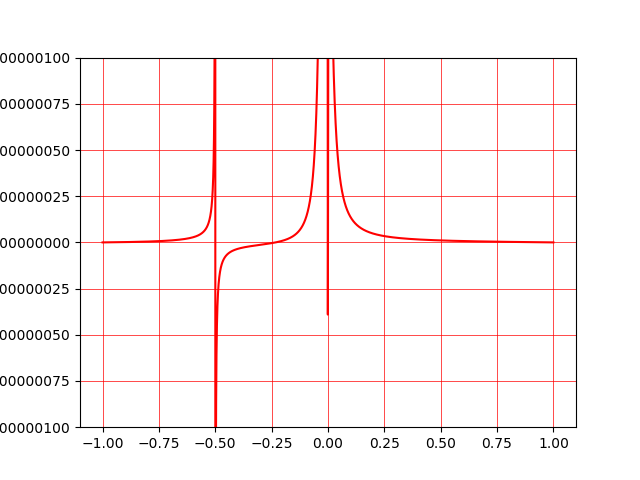

f(0) and f(1) are  -100.999340981 7.10622663544e-14
Best scaling 0.9999999968241782
Value at best scaling 7.03961325396e-14
λ optimisation result
 0.99999520055
λ_min 0
Before Wiggle-v
v is  [  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]
w is  [ 0.816832652433806  0.5768746986287    0.               ]
X-h [[  1.006000000000000e+02   0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.018000000000000e+02   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   1.000000000000000e+10]]
X_g [[   1.                   0.                   0.               ]
 [   0.                 100.200000000000003    0.               ]
 [   0.                   0.                 101.400000000000006]]
gpar is  100000.0
hX is 
 [[  1.006000000000000e+02   0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.018000000000000e+02   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   1.0000000

<IPython.core.display.Javascript object>


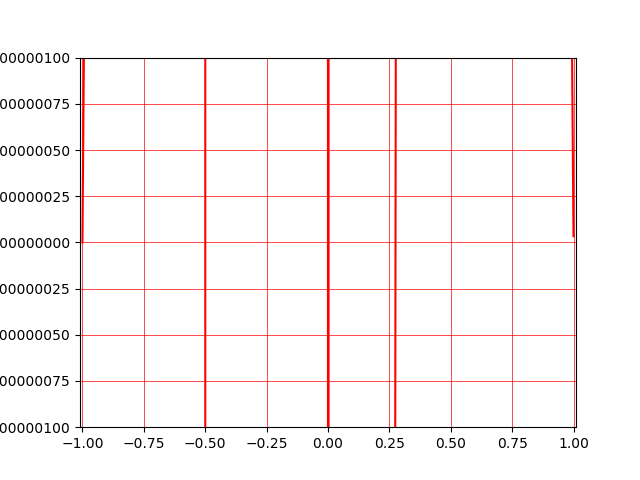

f(0) and f(1) are  -100.57835132 2.09789098005e-09
Best scaling 0.98520656490386
Value at best scaling 1.00421272098e-09
λ optimisation result
 0.999994039139
λ_min 0.999994039139
Before Wiggle-v
v is  [ 0.999919781276408  0.012666136433041]
w is  [ 0.0424883559068    0.999096962067415]
X-h [[  9.999999968241781e+09   0.000000000000000e+00]
 [  0.000000000000000e+00   1.013943145474823e+02]]
X_g [[ 100.594329338703858    0.               ]
 [   0.                   1.000000000050375]]
sub-Unitary
 [[ 0.055139645976505 -0.998478652471642]
 [ 0.998478652471642  0.055139645976505]]
it's square
 [[  1.000000000000000e+00   9.417013080381738e-19]
 [  9.417013080381738e-19   1.000000000000000e+00]]
eigval
 [ 0.055139645976505+0.998478652471642j
  0.055139645976505-0.998478652471642j]
nU
 [[ 0.055139645976505 -0.998478652471642]
 [ 0.998478652471642  0.055139645976505]]


 For a 4x4 Mochon's untrucated ladder rung transition (without axis points)

The Xh matrix: 
 [[  1.006000000000000e+02   

In [106]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
n=2
#l = ladder(n=n,pivot=10,xmax=10E13,Δ=0.1)
#do not try to define xmax here; use gPar.xmax to do this
l = ladder(n=n,pivot=100,Δ=0.4)
#l = ladder(n=n,pivot=50,Δ=0.3) #if you use hscaling for defining Xhp it gives a valid certificate but without it doesn't; the unitaries are exactly the same except one entry with last decimal place different
#l = ladder(n=n,pivot=100,Δ=0.01) #worked even without wiggle v
r = rung(l)
r.selfEval()

print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg)
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

fSize = n+1
size = n+1
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)


uS.base.hEl.X = r.xh + 1E0*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.X[size-1,size-1]=1E10 #120 #1E10
uS.base.hEl.v = r.sqph  #sqph[1:]
uS.base.gEl.X = r.xg + 1E0*np.eye(size)  #gDiag[1:,1:]
uS.base.gEl.v = r.sqpg   #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

uS.selfEval(True,skipλ=True,wiggleV=True,tighten=True)#,manλ=-0.22375)
#uS.iterate(1,skipλ=True)
#uS.iterate(1,skipλ=True,special2d=1)


ax=plt.gca()
ax.set_ylim([-1E-6,1E-6])
ax.set_xlim([-1.1,1.1])




plt.figure(2)
uS.iterate(1,skipλ=False,special2d=-1)
#uS.iterate(1,skipλ=True,special2d=-1)
#uS.iterate(1)

ax=plt.gca()
ax.set_ylim([-1E-6,1E-6])
ax.set_xlim([-1.01,1.01])


# plt.figure(3)
# uS.iterate(1,skipλ=False)
# uS.iterate(1,skipλ=True,special2d=1)

# ax=plt.gca()
# ax.set_ylim([-1E-11,1E-11])
# ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", uS.base.hEl.v)

print("\n\n Solution\n")
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))


#U[0,0]=0.03348068

D =  Xh - U.dot(Xg.dot(U.T))
print("The difference matrix is \n",D)
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

### 3 &rarr; 2 usng renormalisation viz. *without* Wiggle-v

So the basic idea is to use the operator monotone function $f(x)=-1/x$ in conjuction with adding/subtracting identity from the difference equation to get rid of the infinities introduced by the padding procedure.

See the notes for how I get to this final transformation: Start with $$X_g'=\frac{1}{2}\mathbb{I}, X_h'=\mathbb{I}$$ and populate with the given $X_h$ and $X_g$ matrices after applying $$f(x) = \frac{x+1}{x+2}.$$

As it stands, it looks encouraging but doesn't produce the right honest state (only 3 or 4 decimals) with the certificate having a negative eigenvalue of the order -1E-8 or so (which is not that bad).

Lattice
 [   0.                  99.200000000000003   99.599999999999994
  100.400000000000006  100.799999999999997] 
Prob
 [ -1.602048674253442e-02  -1.040907197580668e+06   2.080104116465873e+06
  -2.076682021912361e+06   1.037485119047642e+06]
Initial coordinates
 [[   0.                   0.                   0.               ]
 [   0.                  99.200000000000003    0.               ]
 [   0.                   0.                 100.400000000000006]] 
Initial prob
 [  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]
Final coordinates
 [[  9.959999999999999e+01   0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.008000000000000e+02   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   1.000000000000000e+05]] 
Final prob
 [ 0.816832652433806  0.5768746986287    0.               ]
[  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]


<IPython.core.display.Javascript object>


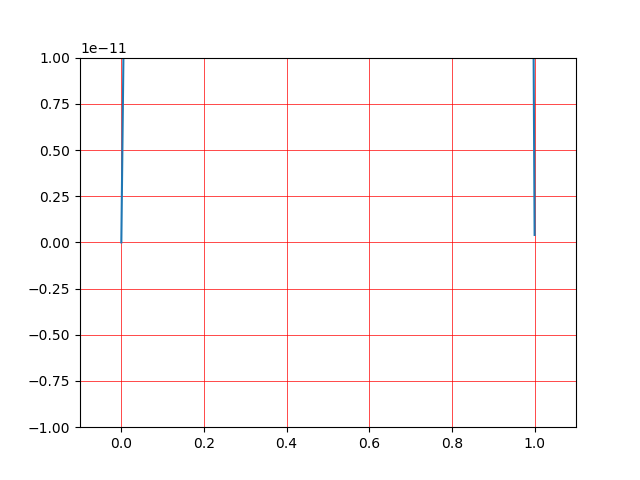

f(0) and f(1) are  -0.999999907136 7.57172102794e-14
Best scaling 0.999999994584723
Value at best scaling 0.0
λ optimisation result
 5.96086092694e-06
λ_min 0
Before Wiggle-v
v is  [  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]
w is  [ 0.816832652433806  0.5768746986287    0.               ]
X-h [[ 0.990157480314961  0.                 0.               ]
 [ 0.                 0.990272373540856  0.               ]
 [ 0.                 0.                 0.999990000199996]]
X_g [[ 0.5                0.                 0.               ]
 [ 0.                 0.990118577075099  0.               ]
 [ 0.                 0.                 0.990234375      ]]
gpar is  100000.0
hX is 
 [[ 0.990157480314961  0.                 0.               ]
 [ 0.                 0.990272373540856  0.               ]
 [ 0.                 0.                 0.999990000199996]]
hX.any >= gPar.xmax/10.0 ? False
gnv/hnv= 0.99999999785 / 0.999999998505
= τ =  0.999999999344
nU
 [[  

<IPython.core.display.Javascript object>


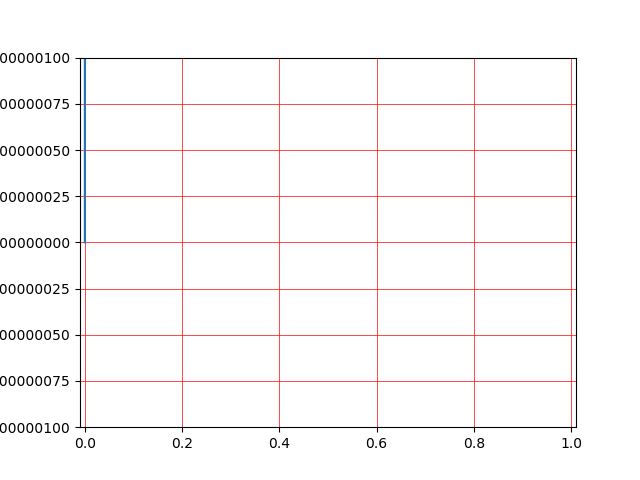

f(0) and f(1) are  -0.999997187851 2.71965266718e-06
Best scaling 0.8549839002656432
Value at best scaling 0.0
λ optimisation result
 5.96086092694e-06
λ_min 0
Before Wiggle-v
v is  [ 0.840945825820196  0.54111931959189 ]
w is  [ 0.  1.]
X-h [[ 0.999989994784773  0.               ]
 [ 0.                 0.990234127582975]]
X_g [[ 0.990157233904567  0.               ]
 [ 0.                 0.50000000064228 ]]
sub-Unitary
 [[ 0.54111931959189  -0.840945825820196]
 [ 0.840945825820196  0.54111931959189 ]]
it's square
 [[  1.000000000000000e+00  -1.196774443677964e-17]
 [ -1.196774443677964e-17   1.000000000000000e+00]]
eigval
 [ 0.54111931959189+0.840945825820196j  0.54111931959189-0.840945825820196j]
nU
 [[ 0.54111931959189  -0.840945825820196]
 [ 0.840945825820196  0.54111931959189 ]]


 For a 4x4 Mochon's untrucated ladder rung transition (without axis points)

The Xh matrix: 
 [[ 0.990157480314961  0.                 0.               ]
 [ 0.                 0.990272373540856  0.      

In [13]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
n=2
#l = ladder(n=n,pivot=10,xmax=10E13,Δ=0.1)
#do not try to define xmax here; use gPar.xmax to do this
l = ladder(n=n,pivot=100,Δ=0.4)
#l = ladder(n=n,pivot=50,Δ=0.3) #if you use hscaling for defining Xhp it gives a valid certificate but without it doesn't; the unitaries are exactly the same except one entry with last decimal place different
#l = ladder(n=n,pivot=100,Δ=0.01) #worked even without wiggle v
r = rung(l)
r.selfEval()

print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg)
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

fSize = n+1
size = n+1
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)

uS.base.hEl.X = 100001/100002*np.eye(size) #100000*np.eye(size)
uS.base.gEl.X = 0.5*np.eye(size) #1*np.eye(size)

#This is not the best fix;
for i in range(size-1):
    uS.base.hEl.X[i,i]=(r.xh[i,i]+1.0) / (r.xh[i,i]+2)
    
for i in range(size):
    uS.base.gEl.X[i,i]=(r.xg[i,i]+1.0) / (r.xg[i,i]+2)


#uS.base.hEl.X = r.xh + 1E1*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
#uS.base.gEl.X = r.xg + 1E1*np.eye(size)  #gDiag[1:,1:]
sm=0.01
#rot=np.array([[1,0,0],[0,np.cos(sm),np.sin(sm)],[0,-np.sin(sm),np.cos(sm)]])
#rot.dot(r.sqph)
uS.base.hEl.v = r.sqph #rot.dot(r.sqph) # r.sqph  #sqph[1:]
uS.base.gEl.v = r.sqpg   #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

uS.selfEval(True,skipλ=False,wiggleV=False)
#uS.selfEval(True,skipλ=False,wiggleV=False)
#uS.iterate(1,skipλ=True,special2d=-1)
#uS.iterate(True,skipλ=True,special2d=1)



ax=plt.gca()
ax.set_ylim([-1E-11,1E-11])
ax.set_xlim([-0.1,1.1])




plt.figure(2)
#uS.iterate(1,skipλ=True,special2d=1)
uS.iterate(True,skipλ=True,special2d=-1,wiggleV=False)
#uS.iterate(True,skipλ=True,special2d=-1)
#uS.iterate(1)

ax=plt.gca()
ax.set_ylim([-1E-6,1E-6])
ax.set_xlim([-0.01,1.01])


# plt.figure(3)
# uS.iterate(1,skipλ=False)
# uS.iterate(1,skipλ=True,special2d=1)

# ax=plt.gca()
# ax.set_ylim([-1E-11,1E-11])
# ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", uS.base.hEl.v)

print("\n\n Solution\n")
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))


#U[0,0]=0.03348068

D =  Xh - U.dot(Xg.dot(U.T))
print("The difference matrix is \n",D)
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

### 3 &rarr; 2 using finite Λ

The idea here is to use the exact result for EBRM with spectrum in (0,λ) by checking operator monotones on (0,λ).

Had to use a τ trick but it seems to work once that is implemented.

Lattice
 [   0.                  99.200000000000003   99.599999999999994
  100.400000000000006  100.799999999999997] 
Prob
 [ -1.602048674253442e-02  -1.040907197580668e+06   2.080104116465873e+06
  -2.076682021912361e+06   1.037485119047642e+06]
Initial coordinates
 [[   0.                   0.                   0.               ]
 [   0.                  99.200000000000003    0.               ]
 [   0.                   0.                 100.400000000000006]] 
Initial prob
 [  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]
Final coordinates
 [[  9.959999999999999e+01   0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.008000000000000e+02   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   1.000000000000000e+05]] 
Final prob
 [ 0.816832652433806  0.5768746986287    0.               ]
[  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]


<IPython.core.display.Javascript object>


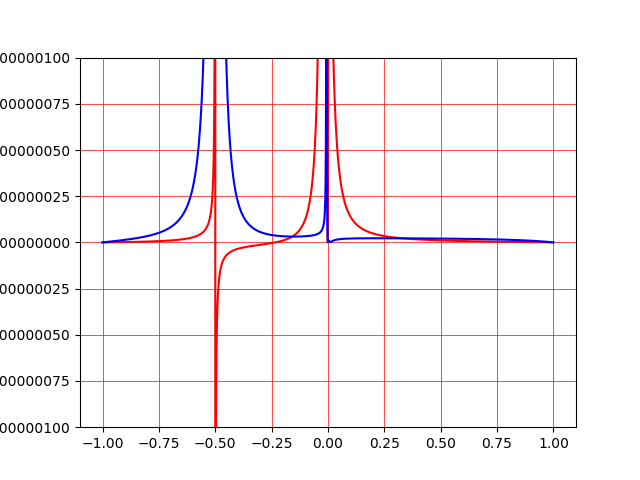

f(0) and f(1) are  -120.142707855 2.55795384874e-13
Best scaling 1.0
Value at best scaling 2.55795384874e-13
λ optimisation result
 -0.000635602624362
λ_min -0.000635602624362
Before Wiggle-v
v is  [  7.168501935384034e-05   5.778253076041775e-01   8.161604675266964e-01]
w is  [ 0.816832652433806  0.5768746986287    0.               ]
X-h [[  100.599999999999994     0.                    0.               ]
 [    0.                  101.799999999999997     0.               ]
 [    0.                    0.                 1000.               ]]
X_g [[   1.                   0.                   0.               ]
 [   0.                 100.200000000000003    0.               ]
 [   0.                   0.                 101.400000000000006]]
gpar is  100000.0
hX is 
 [[  100.599999999999994     0.                    0.               ]
 [    0.                  101.799999999999997     0.               ]
 [    0.                    0.                 1000.               ]]
hX.any >= gPar

<IPython.core.display.Javascript object>


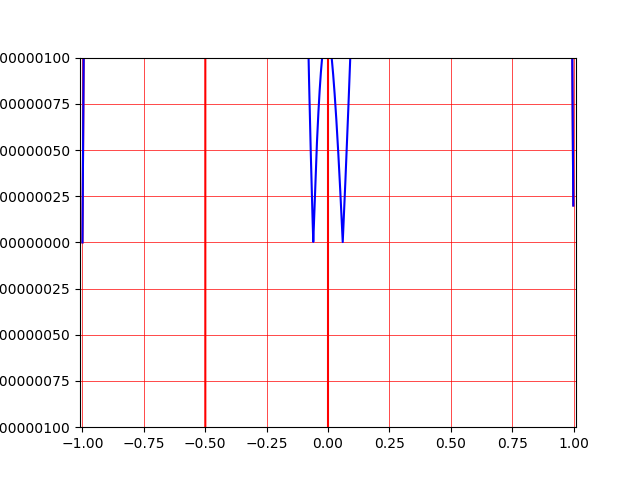

f(0) and f(1) are  -111.922136322 1.70915659403e-09
Best scaling 0.9911015173931149
Value at best scaling 3.20881099469e-11
λ optimisation result
 0.059934210927
λ_min 0
Before Wiggle-v
v is  [ 0.999934954107014  0.011405593145645]
w is  [ 0.  1.]
X-h [[  6.266420547927319e+05   0.000000000000000e+00]
 [  0.000000000000000e+00   1.129270154045730e+02]]
X_g [[ 111.936567528927071    0.               ]
 [   0.                   1.001998800852171]]
sub-Unitary
 [[ 0.011405593145645 -0.999934954107014]
 [ 0.999934954107014  0.011405593145645]]
it's square
 [[  1.000000000000000e+00  -1.343566607375295e-19]
 [ -1.343566607375295e-19   1.000000000000000e+00]]
eigval
 [ 0.011405593145645+0.999934954107014j
  0.011405593145645-0.999934954107014j]
nU
 [[ 0.011405593145645 -0.999934954107014]
 [ 0.999934954107014  0.011405593145645]]


 For a 4x4 Mochon's untrucated ladder rung transition (without axis points)

The Xh matrix: 
 [[  100.599999999999994     0.                    0.               ]

In [242]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
n=2
#l = ladder(n=n,pivot=10,xmax=10E13,Δ=0.1)
#do not try to define xmax here; use gPar.xmax to do this
l = ladder(n=n,pivot=100,Δ=0.4)
#l = ladder(n=n,pivot=50,Δ=0.3) #if you use hscaling for defining Xhp it gives a valid certificate but without it doesn't; the unitaries are exactly the same except one entry with last decimal place different
#l = ladder(n=n,pivot=100,Δ=0.01) #worked even without wiggle v
r = rung(l)
r.selfEval()

print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg)
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

fSize = n+1
size = n+1
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)


uS.base.hEl.X = r.xh + 1E0*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.X[size-1,size-1]=1E3 #120 #1E10
uS.base.hEl.v = r.sqph  #sqph[1:]
uS.base.gEl.X = r.xg + 1E0*np.eye(size)  #gDiag[1:,1:]
uS.base.gEl.v = r.sqpg   #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

#uS.selfEval(True,skipλ=True,wiggleV=False,tighten=False,manλ=-0.0006356559043,lookIn=(-0.001,-0.0001))
uS.selfEval({'debug':True,'skipλ':False,'wiggleV':False,'tighten':True,'lookIn':(-0.001,-0.0001),'τscale':10,'gRes':0.0001})
#uS.iterate(1,skipλ=True)
#uS.iterate(1,skipλ=True,special2d=1)


ax=plt.gca()
ax.set_ylim([-1E-6,1E-6])
ax.set_xlim([-1.1,1.1])




plt.figure(2)
uS.iterate({'debug':1,'skipλ':True,'special2d':-1})
#uS.iterate(1,skipλ=True,special2d=-1)
#uS.iterate(1)

ax=plt.gca()
ax.set_ylim([-1E-6,1E-6])
ax.set_xlim([-1.01,1.01])


# plt.figure(3)
# uS.iterate(1,skipλ=False)
# uS.iterate(1,skipλ=True,special2d=1)

# ax=plt.gca()
# ax.set_ylim([-1E-11,1E-11])
# ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", uS.base.hEl.v)

print("\n\n Solution\n")
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))


#U[0,0]=0.03348068

D =  Xh - U.dot(Xg.dot(U.T))
print("The difference matrix is \n",D)
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

### 2 &rarr;1 Simple Merge using EMA | Wiggle-v (works)

Since the 3 &rarr; 2 method works with wiggle-v but fails with renormalisation therefore it is worth investigating what happens to the simple merge for which I can anlytically obtain expressions and verify equivalence.

Here I try the 2 &rarr; 1 merge *using wiggle-v and it works*. 

NB: The accuracy is not as nice because if I take the padded value to be too large, the honest state gets inaccurate but the certificate gets accurate. If I take the padded value smaller I get a better honest state but the certificate gets worse. This is due to finite precision of the machine.

[ 0.707106781186547  0.707106781186547]


<IPython.core.display.Javascript object>


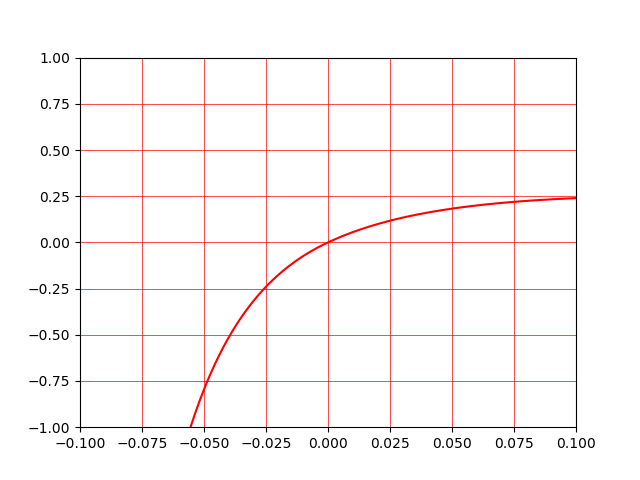

f(0) and f(1) are  -3.0 -4.4408920985e-16
Looks like it's already tight
λ optimisation result
 0.999994029139
λ_min 0
Before Wiggle-v
v is  [ 0.707106781186548  0.707106781186548]
w is  [ 1.  0.]
X-h [[  3.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.000000000000000e+10]]
X_g [[1 0]
 [0 5]]
gpar is  100000.0
hX is 
 [[  3.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.000000000000000e+10]]
hX.any >= gPar.xmax/10.0 ? True
gnv/hnv= 0.832050294338 / 1.0
= τ =  0.832050294338
Implementing Wiggle-v
this is the tangent I picked:  [ 0.  1.]
After Wiggle-v
The h-normal/tangent is 
 [[ 0.832050294337844  0.554700196225229]
 [ 0.554700196225229 -0.832050294337844]]
nU
 [[ 0.707106781186548  0.707106781186547]
 [-0.707106781186547  0.707106781186548]]


 For a 4x4 Mochon's untrucated ladder rung transition (without axis points)

The Xh matrix: 
 [[  3.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.00000000000000

In [55]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
xh = np.array([[3,0],[0,1E10]])
xg = np.array([[1,0],[0,5]])
sqph = np.array([1,0])
sqpg = (1/np.sqrt(2))*np.array([1,1])


fSize = 2
size = 2
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)


uS.base.hEl.X = xh #(xh + 1) / (xh + 2)  #+ 1E1*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.v = sqph   #sqph[1:]
uS.base.gEl.X = xg #(xg + 1)/ (xg + 2) #+ 1E1*np.eye(size)  #gDiag[1:,1:]
uS.base.gEl.v = sqpg  #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

uS.selfEval(True,skipλ=True,wiggleV=True)#,tighten=False)
#uS.iterate(1,skipλ=True)
#uS.selfEval(True,skipλ=True,special2d=1)
#uS.iterate(1,skipλ=True,special2d=1)


ax=plt.gca()
ax.set_ylim([-1E0,1E0])
ax.set_xlim([-0.1,0.1])




# plt.figure(2)
# uS.iterate(1,skipλ=False,special2d=-1)
# #uS.iterate(1,skipλ=True,special2d=-1)
# #uS.iterate(1)

# ax=plt.gca()
# ax.set_ylim([-1E-6,1E-6])
# ax.set_xlim([-0.01,1.01])


# plt.figure(3)
# uS.iterate(1,skipλ=False)
# uS.iterate(1,skipλ=True,special2d=1)

# ax=plt.gca()
# ax.set_ylim([-1E-11,1E-11])
# ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", uS.base.hEl.v)

print("\n\n Solution\n")
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))


#U[0,0]=0.03348068

D =  Xh - U.dot(Xg.dot(U.T))

print("The difference matrix is \n",D)
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)


# #transposed U
# D =  Xh - U.T.dot(Xg.dot(U))

# print("The difference matrix is \n",D)
# eigenval,eigenvec = np.linalg.eigh(D)

# print("The certificate (valid if all non-negative)\n",eigenval)


### 2&rarr;1 Simple Merge using EMA | Renormalised

We use the $$f(x)=\frac{x+1}{x+2}$$ setup and see if the merge works like it should. I especially look forward to the L vs λ graph.

[ 1.414213562373095  1.414213562373095]


<IPython.core.display.Javascript object>


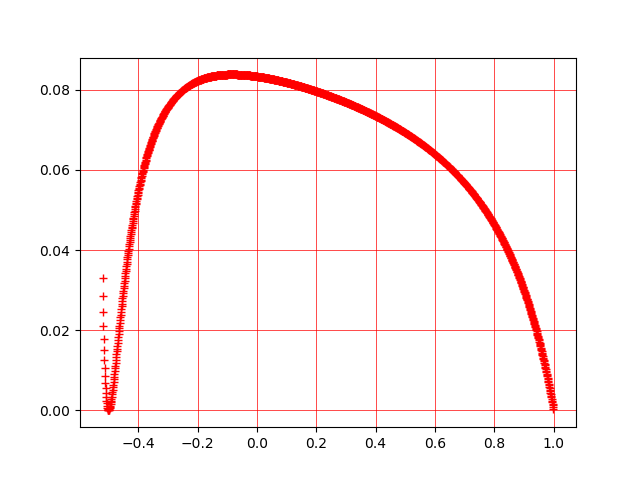

f(0) and f(1) are  -0.999994372695 2.50100895194e-06
λ optimisation result
 0.999994029139
λ_min 0
Before Wiggle-v
v is  [ 0.707106781186548  0.707106781186548]
w is  [ 1.  0.]
X-h [[ 0.75        0.        ]
 [ 0.          0.99999999]]
X_g [[ 0.5                0.               ]
 [ 0.                 0.833333333333333]]
gpar is  100000.0
hX is 
 [[ 0.75        0.        ]
 [ 0.          0.99999999]]
hX.any >= gPar.xmax/10.0 ? False
gnv/hnv= 0.970142500145 / 1.0
= τ =  0.970142500145
nU
 [[ 0.514495755427526  0.857492925712544]
 [ 0.857492925712544 -0.514495755427527]]


 For a 4x4 Mochon's untrucated ladder rung transition (without axis points)

The Xh matrix: 
 [[ 0.75        0.        ]
 [ 0.          0.99999999]]
The Xg matrix: 
 [[ 0.5                0.               ]
 [ 0.                 0.833333333333333]]
The Initial Vector:
 [ 0.707106781186548  0.707106781186548]
The required final vector:
 [ 1.  0.]


 Solution

The final vector obtained:
 [ 0.970142500145332  0.2425356250

<IPython.core.display.Javascript object>


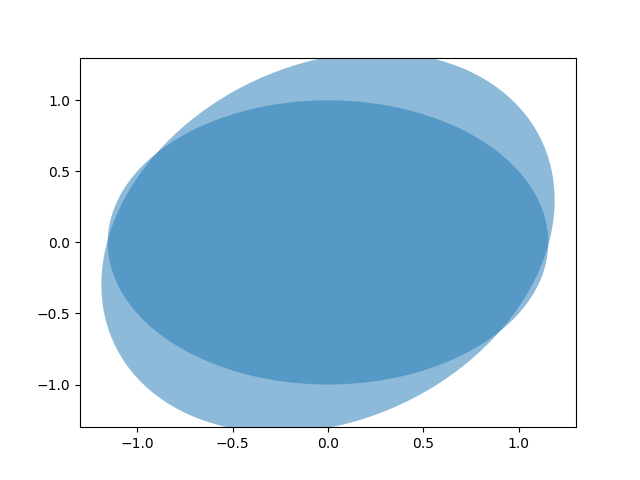

(-1.3, 1.3)

In [47]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
xh = np.array([[3,0],[0,100000000]])
xg = np.array([[1,0],[0,5]])
sqph = np.array([1,0])
sqpg = np.sqrt(2)*np.array([1,1])


fSize = 2
size = 2
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)

for i in range(size):
    uS.base.hEl.X[i,i] = (xh[i,i] ) / (xh[i,i] + 1)  #+ 1E1*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
    uS.base.gEl.X[i,i] = (xg[i,i] )/ (xg[i,i] + 1) #+ 1E1*np.eye(size)  #gDiag[1:,1:]
uS.base.hEl.v = sqph   #sqph[1:]
uS.base.gEl.v = sqpg  #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

uS.selfEval(True,skipλ=True,tighten=False,wiggleV=False)#,special2d=-1)
#uS.iterate(1,skipλ=True)
#uS.selfEval(True,skipλ=True,special2d=1)
#uS.iterate(1,skipλ=True,special2d=1)


ax=plt.gca()
#ax.set_ylim([-1E-9,1E-9])
#ax.set_xlim([-0.1,1.1])




# plt.figure(2)
# uS.iterate(1,skipλ=False,special2d=-1)
# #uS.iterate(1,skipλ=True,special2d=-1)
# #uS.iterate(1)

# ax=plt.gca()
# ax.set_ylim([-1E-6,1E-6])
# ax.set_xlim([-0.01,1.01])


# plt.figure(3)
# uS.iterate(1,skipλ=False)
# uS.iterate(1,skipλ=True,special2d=1)

# ax=plt.gca()
# ax.set_ylim([-1E-11,1E-11])
# ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", uS.base.hEl.v)

print("\n\n Solution\n")
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))


#U[0,0]=0.03348068

D =  Xh - U.dot(Xg.dot(U.T))

print("The difference matrix is \n",D)
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)


# #transposed U
# D =  Xh - U.T.dot(Xg.dot(U))

# print("The difference matrix is \n",D)
# eigenval,eigenvec = np.linalg.eigh(D)

# print("The certificate (valid if all non-negative)\n",eigenval)
plt.figure(2)
scal=1 #0.9523809523809524 #stole from the output below
hEll=Ellipse(xy=(0,0),width=2/(scal*uS.base.hEl.X[0,0])**0.5, height=2/(scal*uS.base.hEl.X[1,1])**0.5, angle=(0)*180/np.pi)
gEll=Ellipse(xy=(0,0),width=2/uS.base.gEl.X[0,0]**0.5, height=2/uS.base.gEl.X[1,1]**0.5, angle= np.arccos(U[0,0]) * 180/np.pi)
hEll.set_alpha(0.5)
gEll.set_alpha(0.5)
#plt.scatter(big.hEl.c[0],big.hEl.c[1]) #this needs to be changed because cs are evaulated for Xps and not Xs
#print("point of contact for the h Ellipsoid", big.hEl.c)
ax = plt.gca()
ax.add_artist(hEll)
ax.add_artist(gEll)
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-1.3,1.3)

### 5&rarr;4 Transition with finite Λ

It seems to work! This is insane!

Lattice
 [  0.                 48.399999999999999  48.799999999999997
  49.200000000000003  49.600000000000001  50.399999999999999
  50.799999999999997  51.200000000000003  51.600000000000001] 
Prob
 [ -3.955500812017979e-02  -1.083206079044706e+14   6.600147825316364e+14
  -1.563718676803604e+15   1.587540104336480e+15  -1.635590866453110e+15
   1.659818296198067e+15  -7.217910683832858e+14   1.220480364782878e+14]
Initial coordinates
 [[  0.                  0.                  0.                  0.                  0.               ]
 [  0.                 48.399999999999999   0.                  0.                  0.               ]
 [  0.                  0.                 49.200000000000003   0.                  0.               ]
 [  0.                  0.                  0.                 50.399999999999999
    0.               ]
 [  0.                  0.                  0.                  0.
   51.200000000000003]] 
Initial prob
 [  3.133137137788771e-09   1.6395860317

<IPython.core.display.Javascript object>


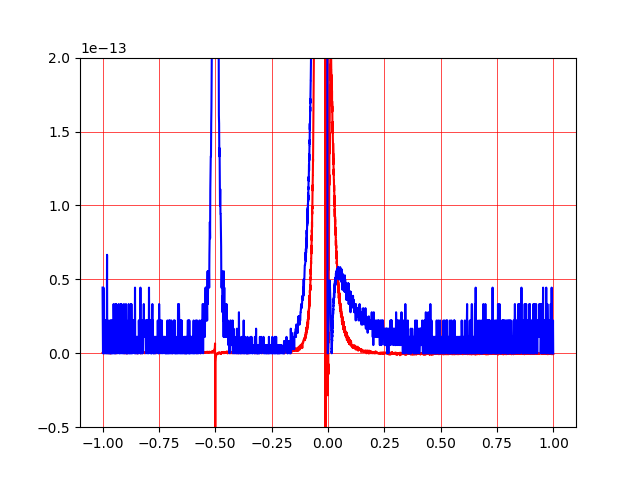

f(0) and f(1) are  -51.0238490119 -1.42108547152e-14
λ optimisation result
 0.2360679775
λ_min -0.0005
Before Wiggle-v
v is  [  3.133137137788772e-09   1.639586031740768e-01   6.229568663753764e-01
   6.371123207821872e-01   4.232377698038217e-01]
w is  [ 0.404720773803955  0.627683941659513  0.641813634930034
  0.174037991979342  0.               ]
X-h [[  49.799999999999997    0.                   0.                   0.
     0.               ]
 [   0.                  50.600000000000001    0.                   0.
     0.               ]
 [   0.                   0.                  51.799999999999997    0.
     0.               ]
 [   0.                   0.                   0.                  52.600000000000001
     0.               ]
 [   0.                   0.                   0.                   0.
   100.               ]]
X_g [[  1.                  0.                  0.                  0.                  0.               ]
 [  0.                 49.399999999999999   0.

<IPython.core.display.Javascript object>


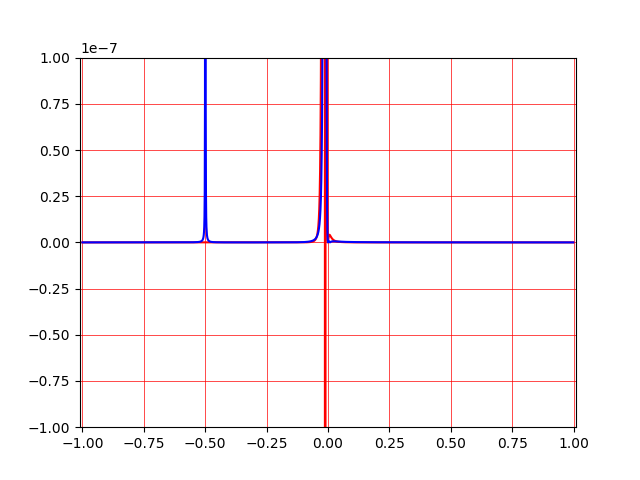

f(0) and f(1) are  -63.9477586349 4.23980850428e-11
Best scaling 0.9999999999989996
Value at best scaling -1.32018840304e-11
λ optimisation result
 -0.000265159260587
λ_min -0.000265159260587
Before Wiggle-v
v is  [  5.133136314058745e-01   8.170117782549490e-01   2.626801667533442e-01
   1.883145825981092e-07]
w is  [ 0.                 0.262918007089748  0.811727128101184
  0.521510489877777]
X-h [[ 108.608644585038974    0.                   0.                   0.               ]
 [   0.                  54.866561407937503    0.                   0.               ]
 [   0.                   0.                  53.398958257547022    0.               ]
 [   0.                   0.                   0.                  52.062134457693404]]
X_g [[ 54.25050877764042    0.                  0.                  0.               ]
 [  0.                 52.869522045840355   0.                  0.               ]
 [  0.                  0.                 51.469944313737614   0.             

<IPython.core.display.Javascript object>


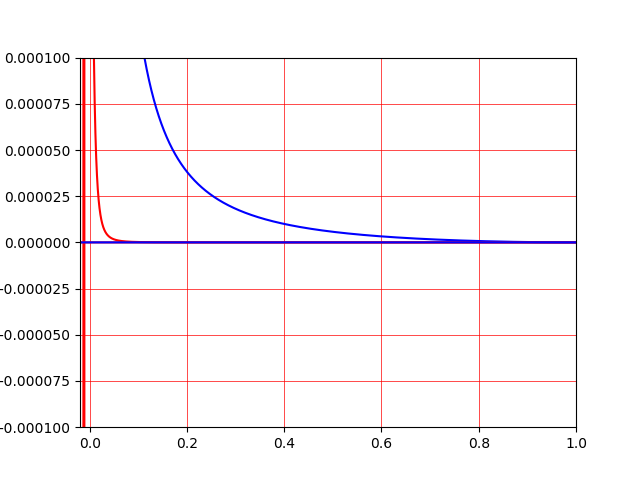

f(0) and f(1) are  -54.3994607094 7.32747196253e-15
Best scaling 0.9999999483362165
Value at best scaling 0.0
λ optimisation result
 0.999958485851
λ_min 0.999
Before Wiggle-v
v is  [  8.366932606447589e-01   5.476717880525666e-01   1.276503841560590e-05]
w is  [ 0.                 0.567558745541064  0.823332903727194]
X-h [[ 113.801906117349915    0.                   0.               ]
 [   0.                  56.042767546969941    0.               ]
 [   0.                   0.                  53.619819699613011]]
X_g [[ 55.114910386830594   0.                  0.               ]
 [  0.                 52.729635987398012   0.               ]
 [  0.                  0.                  1.002407367563023]]
gpar is  100000.0
hX is 
 [[ 113.801906117349915    0.                   0.               ]
 [   0.                  56.042767546969941    0.               ]
 [   0.                   0.                  53.619819699613011]]
hX.any >= gPar.xmax/10.0 ? False
gnv/hnv= 1.0 / 1.0
= τ =

In [283]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
n=4
#l = ladder(n=n,pivot=10,xmax=10E13,Δ=0.1)
#do not try to define xmax here; use gPar.xmax to do this
l = ladder(n=n,pivot=50,Δ=0.4)
#l = ladder(n=n,pivot=50,Δ=0.3) #if you use hscaling for defining Xhp it gives a valid certificate but without it doesn't; the unitaries are exactly the same except one entry with last decimal place different
#l = ladder(n=n,pivot=100,Δ=0.01) #worked even without wiggle v
r = rung(l)
r.selfEval()

print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg)
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

fSize = n+1
size = n+1
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)

uS.base.hEl.X = 1E2*np.eye(size)
uS.base.gEl.X = np.eye(size)

#This is not the best fix;
for i in range(size-1):
    uS.base.hEl.X[i,i]=r.xh[i,i]+1 #(r.xh[i,i]+1.0) / (r.xh[i,i]+2)
    
for i in range(size):
    uS.base.gEl.X[i,i]=r.xg[i,i]+1 #(r.xg[i,i]+1.0) / (r.xg[i,i]+2)


#uS.base.hEl.X = r.xh + 1E1*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
#uS.base.gEl.X = r.xg + 1E1*np.eye(size)  #gDiag[1:,1:]

uS.base.hEl.v = r.sqph  #sqph[1:]
uS.base.gEl.v = r.sqpg   #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

#uS.selfEval(True,skipλ=False,lookIn=(-0.0005,0.0005),tighten=False)
uS.selfEval({'debug':True,'skipλ':True,'tighten':False,'τscale':1E2,'manλ':-0.0005})
#uS.selfEval(True,skipλ=False,wiggleV=False)
#uS.iterate(1,skipλ=True,special2d=-1)
#uS.iterate(True,skipλ=True,special2d=1)



ax=plt.gca()
#ax.set_ylim([-1E-11,1E-11])
ax.set_ylim([-5E-14,2E-13])

ax.set_xlim([-1.1,1.1])




plt.figure(2)
##uS.iterate(True,skipλ=True,manλ=0.999999,tighten=False,lookIn=(-0.002,0.0)) #wiggleV=True)tighten=True,
uS.iterate({'debug':True,'skipλ':False,'tighten':True,'lookIn':(-0.002,0.0),'τscale':1E2}) #wiggleV=True)tighten=True,

ax=plt.gca()
ax.set_ylim([-1E-7,1E-7])
ax.set_xlim([-1.01,1.01])


plt.figure(3)
uS.iterate({'debug':True,'skipλ':True,'manλ':0.999,'tighten':True,'lookIn':(0.2,1),'countIn':2,\
            'gRes':0.00001,'gResIn':(0.,0.9),'τscale':1E4})
##uS.iterate(True,skipλ=True,manλ=0.9999999999)
uS.iterate({'debug':True,'skipλ':True,'manλ':0,'special2d':1})
    
    

ax=plt.gca()
ax.set_ylim([-1E-4,1E-4])
ax.set_xlim([-0.02,1])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", uS.base.hEl.v)

print("\n\n Solution\n")
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))


#U[0,0]=0.03348068

D =  Xh - U.dot(Xg.dot(U.T))
print("The difference matrix is \n",D)
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

Xh[size-1,size-1]=1E6
D =  Xh - U.dot(Xg.dot(U.T))
print("The difference matrix is \n",D)
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)


### 5&rarr;4 Transition Try

With everything the same and a smaller padded eigenvalue it seems to produce an almost valid certificate! Amazing.

Lattice
 [  0.                 48.399999999999999  48.799999999999997
  49.200000000000003  49.600000000000001  50.399999999999999
  50.799999999999997  51.200000000000003  51.600000000000001] 
Prob
 [ -3.955500812017979e-02  -1.083206079044706e+14   6.600147825316364e+14
  -1.563718676803604e+15   1.587540104336480e+15  -1.635590866453110e+15
   1.659818296198067e+15  -7.217910683832858e+14   1.220480364782878e+14]
Initial coordinates
 [[  0.                  0.                  0.                  0.                  0.               ]
 [  0.                 48.399999999999999   0.                  0.                  0.               ]
 [  0.                  0.                 49.200000000000003   0.                  0.               ]
 [  0.                  0.                  0.                 50.399999999999999
    0.               ]
 [  0.                  0.                  0.                  0.
   51.200000000000003]] 
Initial prob
 [  3.133137137788771e-09   1.6395860317

<IPython.core.display.Javascript object>


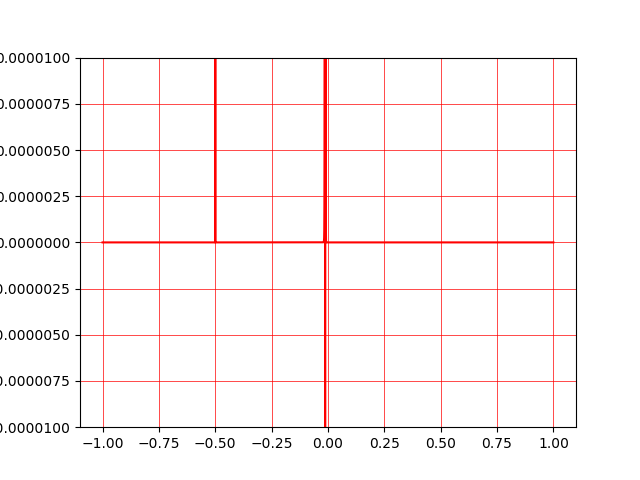

f(0) and f(1) are  -51.0238490119 -1.42108547152e-14
Looks like it's already tight
λ optimisation result
 0.353216186717
λ_min 0
Before Wiggle-v
v is  [  3.133137137788772e-09   1.639586031740768e-01   6.229568663753764e-01
   6.371123207821872e-01   4.232377698038217e-01]
w is  [ 0.404720773803955  0.627683941659513  0.641813634930034
  0.174037991979342  0.               ]
X-h [[    49.799999999999997      0.                     0.                     0.
       0.               ]
 [     0.                    50.600000000000001      0.                     0.
       0.               ]
 [     0.                     0.                    51.799999999999997
       0.                     0.               ]
 [     0.                     0.                     0.
      52.600000000000001      0.               ]
 [     0.                     0.                     0.                     0.
   10000.               ]]
X_g [[  1.                  0.                  0.                  0.       

<IPython.core.display.Javascript object>


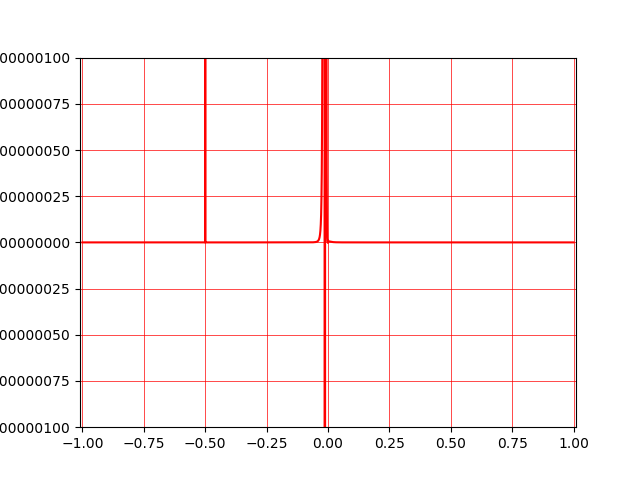

f(0) and f(1) are  -60.8429355127 -4.14326180476e-07
Looks like it's already tight
λ optimisation result
 -6.36619778558e-05
λ_min 0
Before Wiggle-v
v is  [  5.130331322494659e-01   8.171082787996522e-01   2.629278721081763e-01
   1.960132733261797e-07]
w is  [  9.507559173097923e-07   2.626597522125937e-01   8.116362774307986e-01
   5.217819541963776e-01]
X-h [[ 10000.                     0.                     0.                     0.               ]
 [     0.                    52.560383028571316      0.                     0.               ]
 [     0.                     0.                    51.211324163385235
       0.               ]
 [     0.                     0.                     0.
      49.979390097526064]]
X_g [[ 51.994429619746448   0.                  0.                  0.               ]
 [  0.                 50.723806670053591   0.                  0.               ]
 [  0.                  0.                 49.432860999682987   0.               ]
 [  0.        

<IPython.core.display.Javascript object>


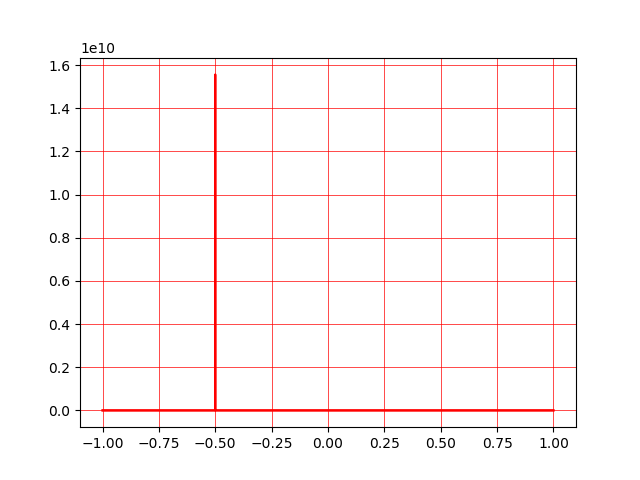

f(0) and f(1) are  -50.9988438974 2.14874784632e-11
Best scaling 0.9998171453538603
Value at best scaling 0.0
λ optimisation result
 0.999995362601
λ_min 0.999999
Before Wiggle-v
v is  [  8.357493269329952e-01   5.491111566260140e-01   1.413813648214510e-05]
w is  [ 0.013650071060121  0.566042201521219  0.824263247789846]
X-h [[ 9999.99965388083001      0.                    0.               ]
 [    0.                   52.446549473030665     0.               ]
 [    0.                    0.                   50.316712141853564]]
X_g [[ 51.6326675055683     0.                  0.               ]
 [  0.                 49.530594141247178   0.               ]
 [  0.                  0.                  1.000000000000001]]
gpar is  100000.0
hX is 
 [[ 9999.99965388083001      0.                    0.               ]
 [    0.                   52.446549473030665     0.               ]
 [    0.                    0.                   50.316712141853564]]
hX.any >= gPar.xmax/10.0 ? False
gnv

In [159]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
n=4
#l = ladder(n=n,pivot=10,xmax=10E13,Δ=0.1)
#do not try to define xmax here; use gPar.xmax to do this
l = ladder(n=n,pivot=50,Δ=0.4)
#l = ladder(n=n,pivot=50,Δ=0.3) #if you use hscaling for defining Xhp it gives a valid certificate but without it doesn't; the unitaries are exactly the same except one entry with last decimal place different
#l = ladder(n=n,pivot=100,Δ=0.01) #worked even without wiggle v
r = rung(l)
r.selfEval()

print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg)
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

fSize = n+1
size = n+1
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)

uS.base.hEl.X = 1E4*np.eye(size)
uS.base.gEl.X = np.eye(size)

#This is not the best fix;
for i in range(size-1):
    uS.base.hEl.X[i,i]=r.xh[i,i]+1 #(r.xh[i,i]+1.0) / (r.xh[i,i]+2)
    
for i in range(size):
    uS.base.gEl.X[i,i]=r.xg[i,i]+1 #(r.xg[i,i]+1.0) / (r.xg[i,i]+2)


#uS.base.hEl.X = r.xh + 1E1*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
#uS.base.gEl.X = r.xg + 1E1*np.eye(size)  #gDiag[1:,1:]

uS.base.hEl.v = r.sqph  #sqph[1:]
uS.base.gEl.v = r.sqpg   #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

uS.selfEval(True,skipλ=True,wiggleV=True,tighten=True)
#uS.selfEval(True,skipλ=False,wiggleV=False)
#uS.iterate(1,skipλ=True,special2d=-1)
#uS.iterate(True,skipλ=True,special2d=1)



ax=plt.gca()
ax.set_ylim([-1E-5,1E-5])
ax.set_xlim([-1.1,1.1])




plt.figure(2)
#uS.iterate(1,skipλ=True,special2d=1)
uS.iterate(True,skipλ=True,manλ=0,lookIn=(-0.002,0.0))#wiggleV=True)tighten=True,
#uS.iterate(1)

ax=plt.gca()
ax.set_ylim([-1E-6,1E-6])
ax.set_xlim([-1.01,1.01])


plt.figure(3)
uS.iterate(True,skipλ=True,manλ=0.999999)
uS.iterate(True,skipλ=True,manλ=0,special2d=-1)
    
    
# uS.iterate(1,skipλ=False)
# uS.iterate(1,skipλ=True,special2d=1)

# ax=plt.gca()
# ax.set_ylim([-1E-11,1E-11])
# ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The required final vector:\n", uS.base.hEl.v)

print("\n\n Solution\n")
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))


#U[0,0]=0.03348068

D =  Xh - U.dot(Xg.dot(U.T))
print("The difference matrix is \n",D)
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

### 5 &rarr; 4 Main Ladder Move (5d)

Lattice
 [  0.   34.   35.5  37.   38.5  41.5  43.   44.5  46. ] 
Prob
 [ -2.020252732455264e-01  -6.463444272499998e+09   4.187120640961919e+10
  -1.051367703407614e+11   1.127948130706801e+11  -1.287523300991105e+11
   1.370415189812919e+11  -6.237038165589013e+10   1.101538790687278e+10]
Initial coordinates
 [[  0.    0.    0.    0.    0. ]
 [  0.   34.    0.    0.    0. ]
 [  0.    0.   37.    0.    0. ]
 [  0.    0.    0.   41.5   0. ]
 [  0.    0.    0.    0.   44.5]] 
Initial prob
 [  8.169212532324388e-07   1.461198937858835e-01   5.893247212887184e-01
   6.521611025691292e-01   4.539066487870902e-01]
Final coordinates
 [[  3.550000000000000e+01   0.000000000000000e+00   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   3.850000000000000e+01   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   4.300000000000000e+01
    0.000000000000000e+00   0.0000000000

<IPython.core.display.Javascript object>


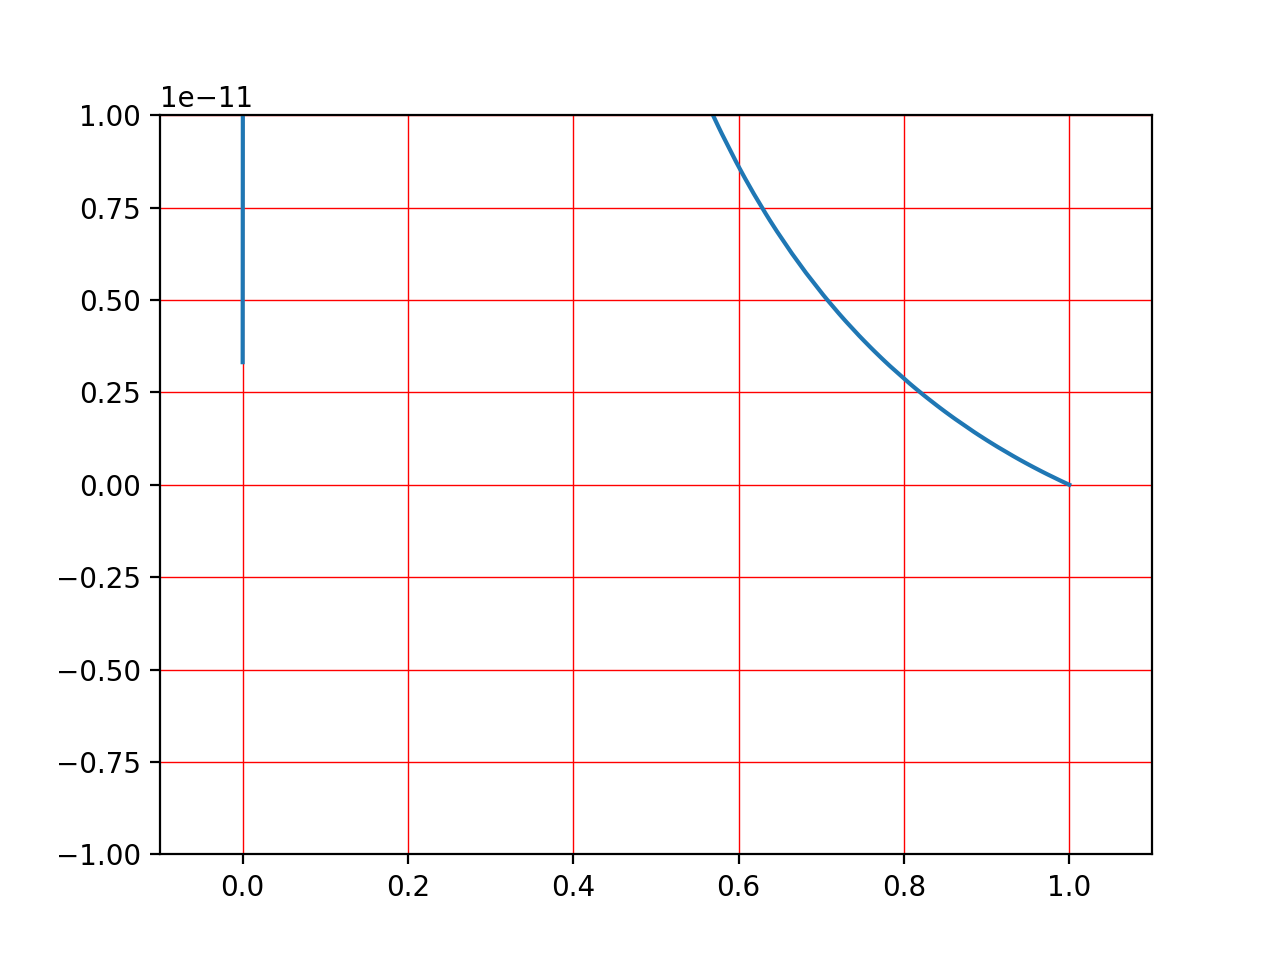

f(0) and f(1) are  -50.3950947402 2.22044604925e-16
Best scaling 1.0
Value at best scaling 2.22044604925e-16
λ optimisation result
 0.999996022622
λ_min 0
Before Wiggle-v
v is  [  8.169212532324388e-07   1.461198937858835e-01   5.893247212887184e-01
   6.521611025691292e-01   4.539066487870902e-01]
w is  [ 0.371907623323173  0.610410376852455  0.67282702223865   0.190755575778073
  0.               ]
X-h [[  4.550000000000000e+01   0.000000000000000e+00   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   4.850000000000000e+01   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   5.300000000000000e+01
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   0.000000000000000e+00
    5.600000000000000e+01   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   0.000000000000000e+00
    0.000000000000

<IPython.core.display.Javascript object>


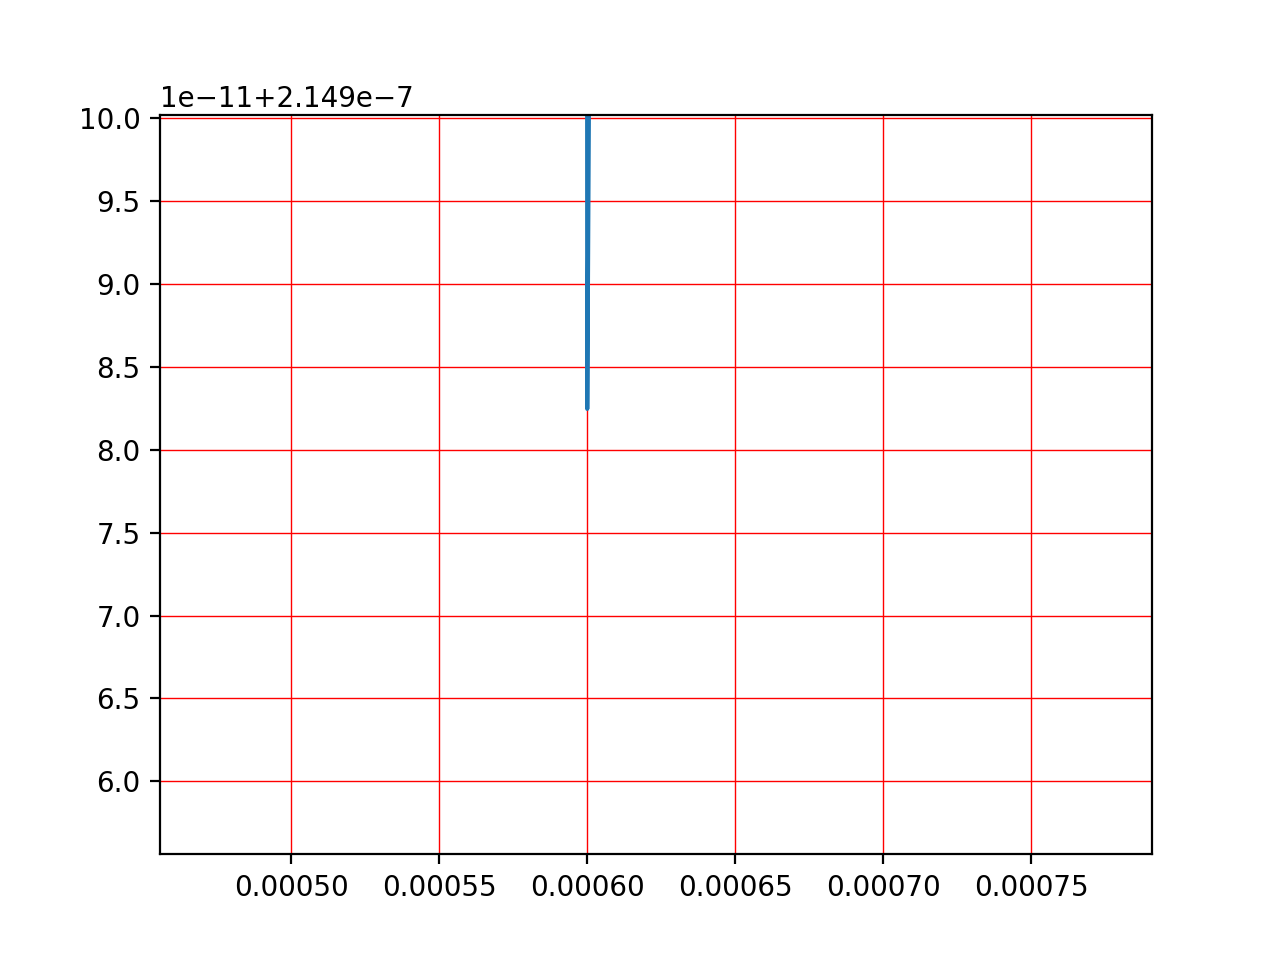

f(0) and f(1) are  -49.5554367075 1.33226762955e-14
Best scaling 0.9999999100406851
Value at best scaling 0.0
λ optimisation result
 0.999996571671
λ_min 0.0006
Before Wiggle-v
v is  [  5.044101300518304e-01   8.234209783157999e-01   2.599005830069733e-01
   1.109873673645961e-05]
w is  [  3.742642081566711e-05   2.649871404146301e-01   8.041356060971862e-01
   5.321162852430391e-01]
X-h [[  1.000099999995112e+05   0.000000000000000e+00   0.000000000000000e+00
    0.000000000000000e+00]
 [  0.000000000000000e+00   5.580988556743505e+01   0.000000000000000e+00
    0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   5.042305692148722e+01
    0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   0.000000000000000e+00
    4.602298088955167e+01]]
X_g [[ 53.578058837182596   0.                  0.                  0.               ]
 [  0.                 48.590718549655804   0.                  0.               ]
 [  0.                  0.        

<IPython.core.display.Javascript object>


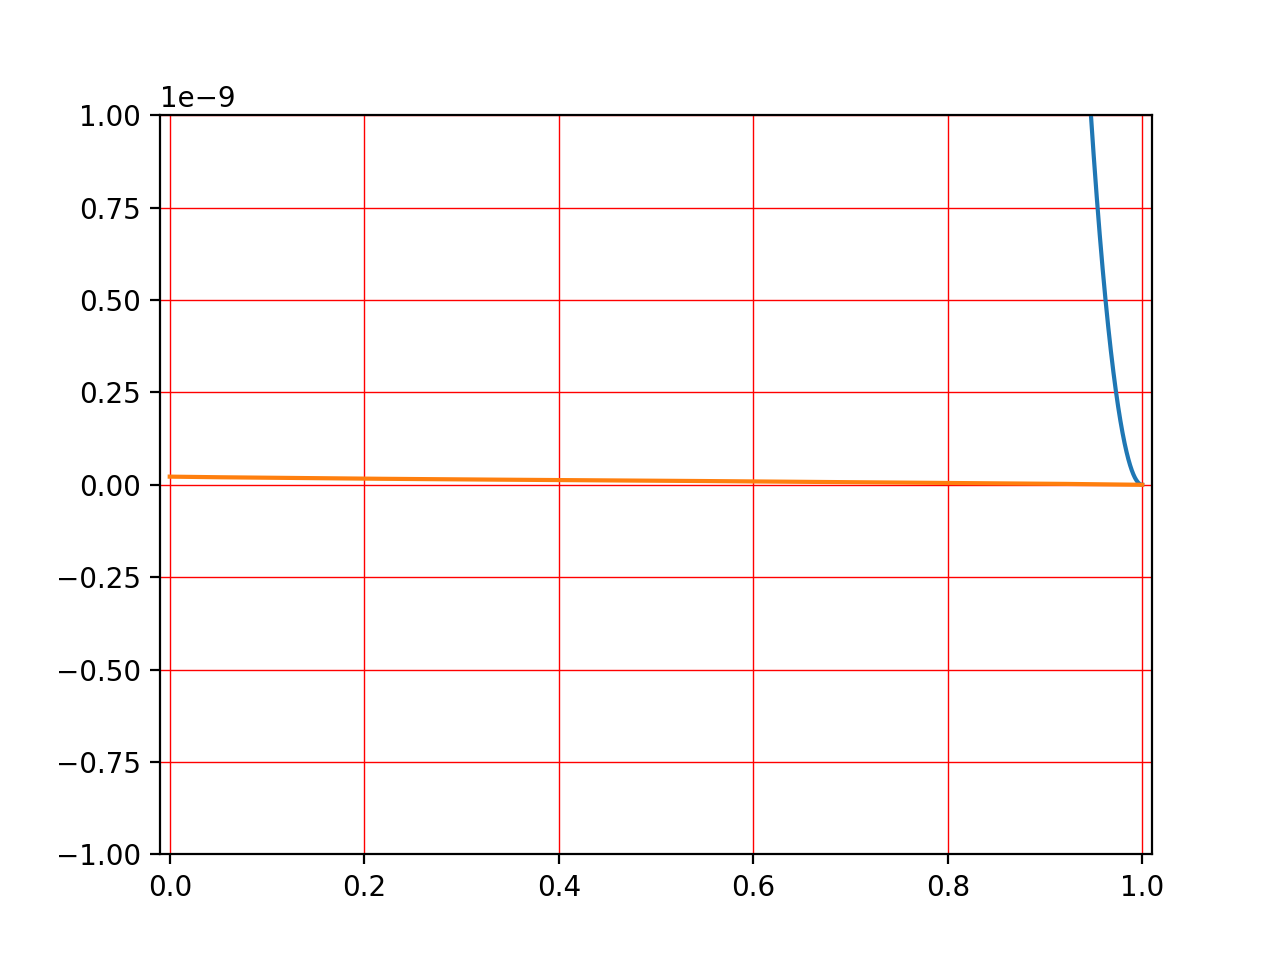

f(0) and f(1) are  -47.7775192652 4.68158845024e-12
Best scaling 0.9999713745653921
Value at best scaling 0.0
λ optimisation result
 0.999994198704
λ_min 0.999994198704
Before Wiggle-v
v is  [  8.550241554459106e-01   5.185881437981921e-01   1.752596733665433e-04]
w is  [ 0.015787937268749  0.593346599841718  0.804792242440911]
X-h [[ 1050.882846862717997     0.                    0.               ]
 [    0.                   52.584264260564886     0.               ]
 [    0.                    0.                   45.196447030091825]]
X_g [[ 49.669880061546792   0.                  0.               ]
 [  0.                 42.633350848376168   0.               ]
 [  0.                  0.                  9.915968947687379]]
gpar is  100000.0
hX is 
 [[ 1050.882846862717997     0.                    0.               ]
 [    0.                   52.584264260564886     0.               ]
 [    0.                    0.                   45.196447030091825]]
hX.any >= gPar.xmax/10.0 ? Fal

In [219]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
n=4
#l = ladder(n=n,pivot=10,xmax=10E13,Δ=0.1)
#do not try to define xmax here; use gPar.xmax to do this
l = ladder(n=n,pivot=40,Δ=1.5,trunc=True)

#l = ladder(n=n,pivot=100,Δ=0.01)
r = rung(l)
r.selfEval()

print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg)
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

fSize = n+1
size = n+1
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)


uS.base.hEl.X = r.xh + 1E1*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.v = r.sqph  #sqph[1:]
uS.base.gEl.X = r.xg + 1E1*np.eye(size)  #gDiag[1:,1:]
uS.base.gEl.v = r.sqpg   #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

uS.selfEval(True,skipλ=True,wiggleV=True)

#uS.iterate(1,skipλ=True,special2d=1)


ax=plt.gca()
ax.set_ylim([-1E-11,1E-11])
ax.set_xlim([-0.1,1.1])




plt.figure(2)
uS.iterate(1,skipλ=True,manλ=0.0006,wiggleV=False)

ax=plt.gca()
ax.set_ylim([-1E-9,1E-9])
ax.set_xlim([-0.01,1.01])



plt.figure(3)
uS.iterate(1,skipλ=False,manλ=0.0335,wiggleV=False)#0.0335
#uS.iterate(1,skipλ=False,wiggleV=False) #special2d=-1)
uS.iterate(1,skipλ=True,special2d=1)
#uS.iterate(1,skipλ=False)

ax=plt.gca()
ax.set_ylim([-1E-9,1E-9])
ax.set_xlim([-0.01,1.01])


# plt.figure(3)
# uS.iterate(1,skipλ=False)
# uS.iterate(1,skipλ=True,special2d=1)

# ax=plt.gca()
# ax.set_ylim([-1E-10,1E-10])
# ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))

print("\n\n Solution\n")
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))
print("The required final vector:\n", uS.base.hEl.v)



D =  Xh - U.dot(Xg.dot(U.T))
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

In [21]:
np.finfo(np.float).precision

15

 (with -1 phase)
 [ -1.16987577e-03  -4.46732452e-07   1.87724525e-06   4.01291035e+00
   1.00000000e+10]
   
(with 1 phase)
[ -1.17193247e-03  -2.74238303e-07   6.98804105e-07   4.01236867e+00
   1.00000000e+10]
   
|something | something |
| -- | -- |
|-1.52839870e-03 | 0.8  
|-1.52385540e-03 | 0.7
|-1.51785209e-03 | 0.5


### 5 &rarr; 4 Transition | 6d implementation

Lattice
 [  0.   34.   35.5  37.   38.5  41.5  43.   44.5  46. ] 
Prob
 [ -2.020252732455264e-01  -6.463444272499998e+09   4.187120640961919e+10
  -1.051367703407614e+11   1.127948130706801e+11  -1.287523300991105e+11
   1.370415189812919e+11  -6.237038165589013e+10   1.101538790687278e+10]
Initial coordinates
 [[  0.    0.    0.    0.    0. ]
 [  0.   34.    0.    0.    0. ]
 [  0.    0.   37.    0.    0. ]
 [  0.    0.    0.   41.5   0. ]
 [  0.    0.    0.    0.   44.5]] 
Initial prob
 [  8.169212532324388e-07   1.461198937858835e-01   5.893247212887184e-01
   6.521611025691292e-01   4.539066487870902e-01]
Final coordinates
 [[  3.550000000000000e+01   0.000000000000000e+00   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   3.850000000000000e+01   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   4.300000000000000e+01
    0.000000000000000e+00   0.0000000000

<IPython.core.display.Javascript object>


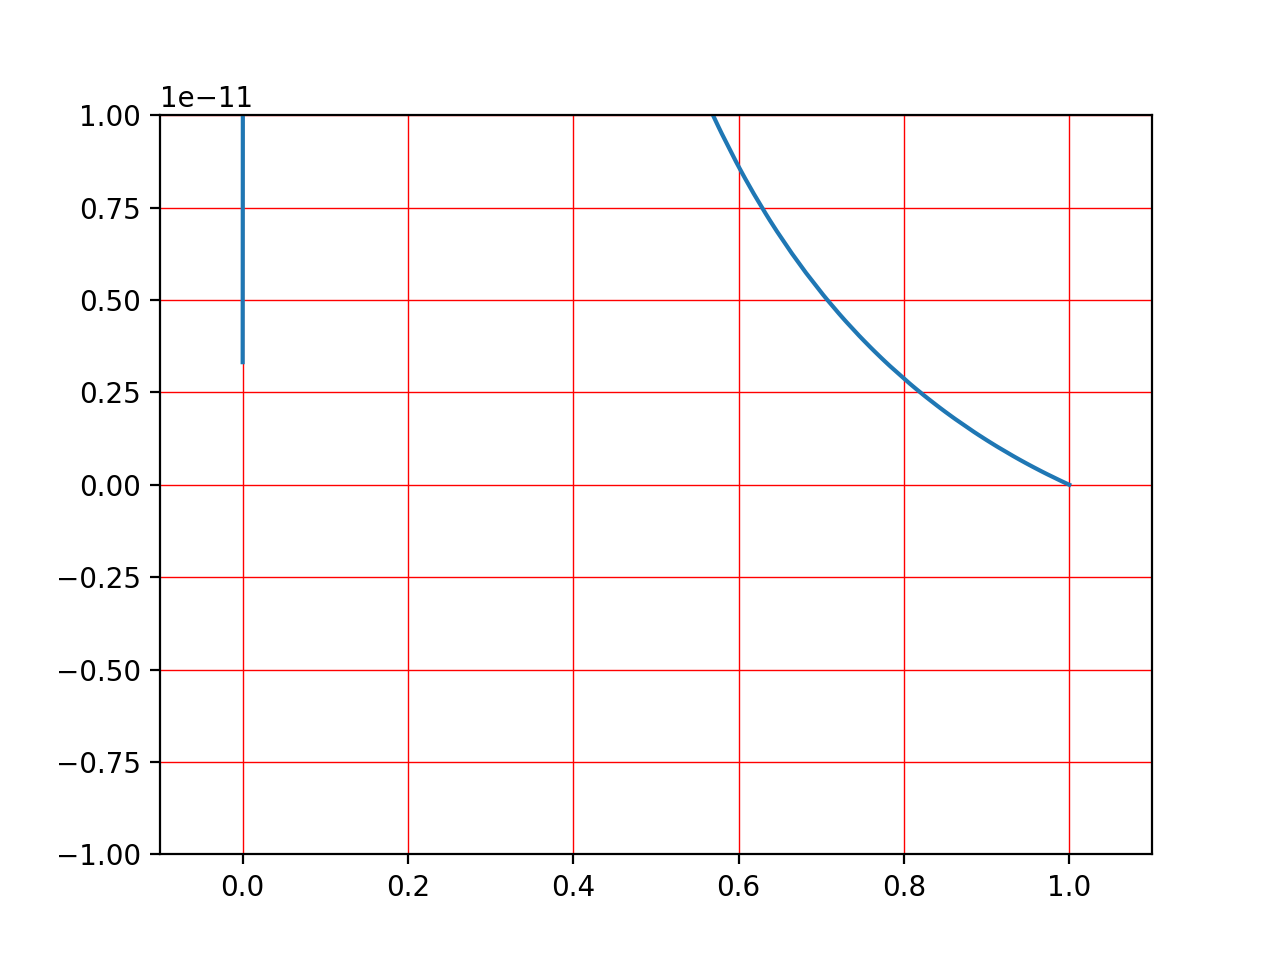

f(0) and f(1) are  -50.3950947402 2.22044604925e-16
Best scaling 1.0
Value at best scaling 2.22044604925e-16
λ optimisation result
      fun: 2.2204460492503131e-16
 message: 'Solution found.'
    nfev: 26
  status: 0
 success: True
       x: 0.99999602262183873
λ_min 0
Before Wiggle-v
v is  [  8.169212532324388e-07   1.461198937858835e-01   5.893247212887184e-01
   6.521611025691292e-01   4.539066487870902e-01   0.000000000000000e+00]
w is  [ 0.371907623323173  0.610410376852455  0.67282702223865   0.190755575778073
  0.                 0.               ]
X-h [[  4.550000000000000e+01   0.000000000000000e+00   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   4.850000000000000e+01   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   5.300000000000000e+01
    0.000000000000000e+00   0.000000000000000e+00   0.0000000

<IPython.core.display.Javascript object>


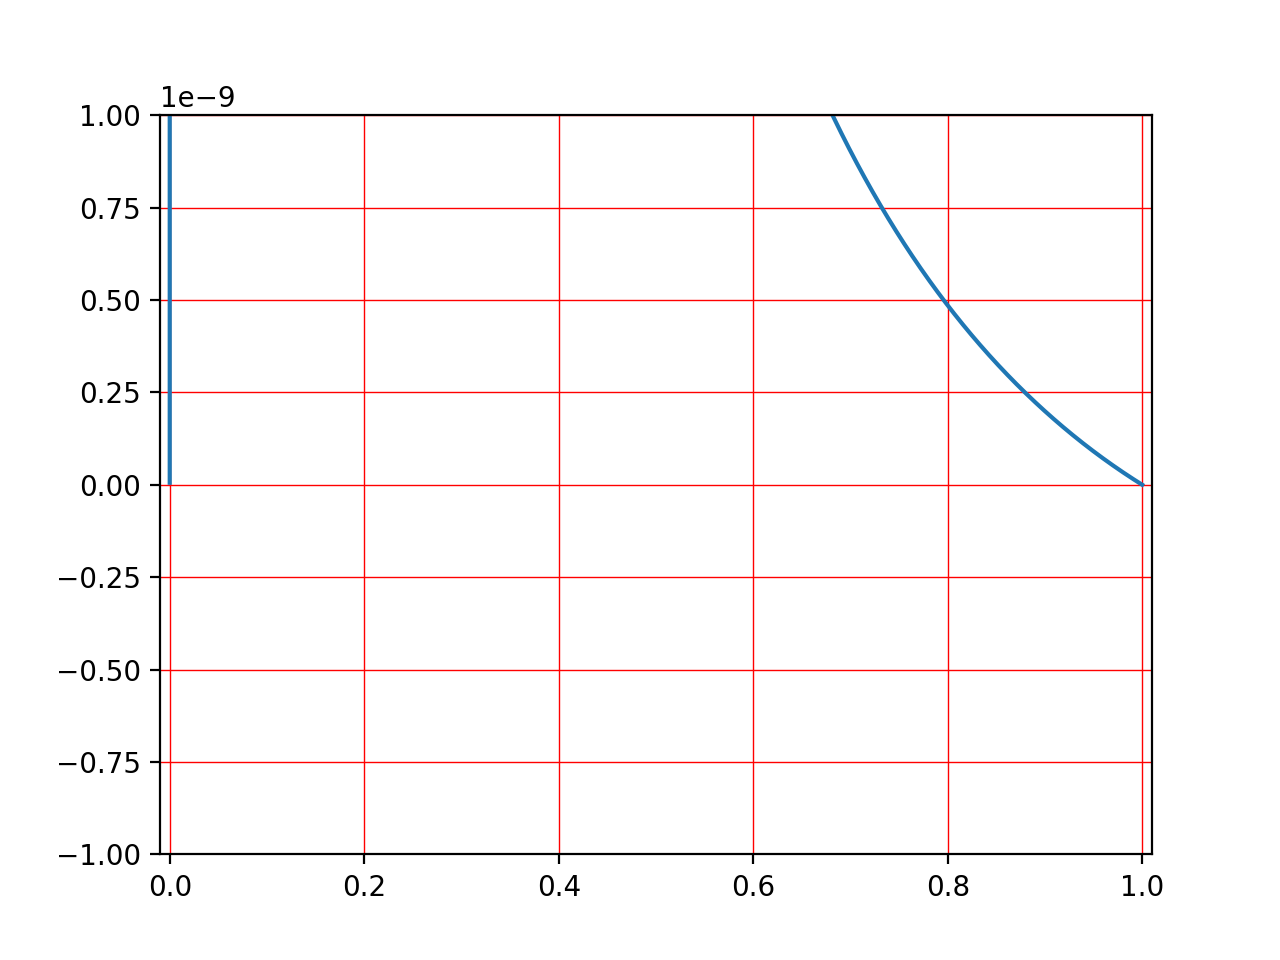

f(0) and f(1) are  -49.5554367075 1.33226762955e-14
Best scaling 0.9999999606063699
Value at best scaling 8.21565038223e-15
λ optimisation result
      fun: 8.2156503822261584e-15
 message: 'Solution found.'
    nfev: 26
  status: 0
 success: True
       x: 0.99999490100710542
λ_min 0.0045
Before Wiggle-v
v is  [  5.044101300518291e-01   8.234209783157997e-01   2.599005830069762e-01
   1.109873673693014e-05   1.176354516224326e-15]
w is  [ 0.                 0.                 0.264987140600222
  0.804135606660374  0.53211628561572 ]
X-h [[  1.000100000000000e+05   0.000000000000000e+00   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   9.999999999999999e+04   0.000000000000000e+00
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   5.580988556743503e+01
    0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   0.000000000000000e+00
    5.0

<IPython.core.display.Javascript object>


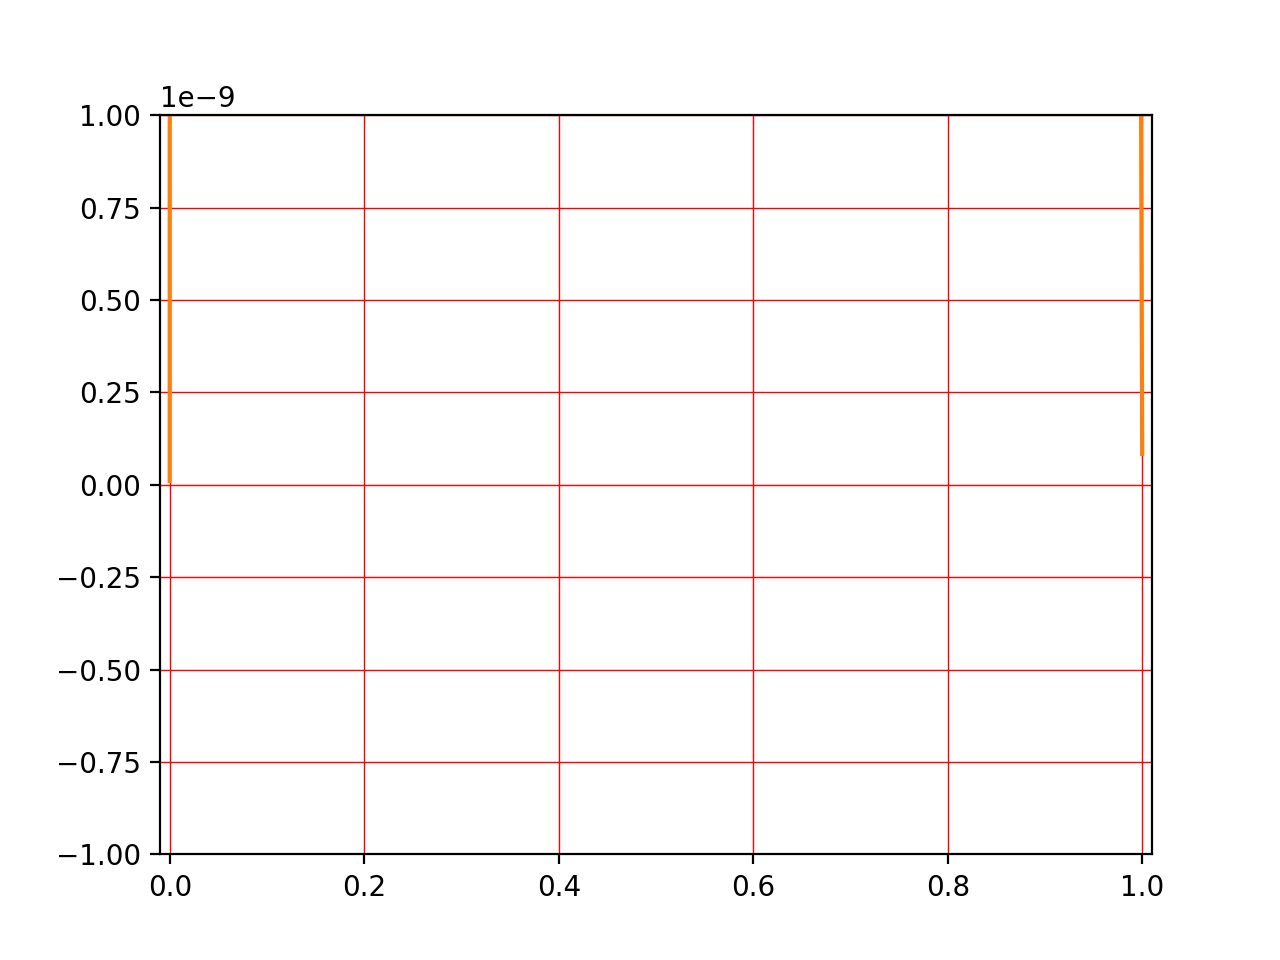

f(0) and f(1) are  -37.1240819819 -0.00616393044921
Looks like it's already tight
λ optimisation result
      fun: -0.0061639304492118185
 message: 'Solution found.'
    nfev: 19
  status: 0
 success: True
       x: 0.0010202011631841171
λ_min 0
Before Wiggle-v
v is  [  8.479919552354445e-01   5.300090549142605e-01   2.134592712526061e-04
  -2.865191429662299e-15]
w is  [ 0.                 0.                 0.581507832048264
  0.813540804917939]
X-h [[ 142.267460507189782    0.                   0.                   0.               ]
 [   0.                 142.267440411237601    0.                   0.               ]
 [   0.                   0.                  40.031139406200246    0.               ]
 [   0.                   0.                   0.                  35.629642100811893]]
X_g [[ 38.336059432305397   0.                  0.                  0.               ]
 [  0.                 34.021589084652263   0.                  0.               ]
 [  0.                  0

In [156]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(precision=15)

####THE 4x4 CASE (even the assymetric situtation seems to work) ####
n=4
#l = ladder(n=n,pivot=10,xmax=10E13,Δ=0.1)
#do not try to define xmax here; use gPar.xmax to do this
l = ladder(n=n,pivot=40,Δ=1.5,trunc=True)

#l = ladder(n=n,pivot=100,Δ=0.01)
r = rung(l)
r.selfEval()

print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg)
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

#extra padding
m = 1

fSize = n+1+m
size = n+1+m
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)


uS.base.hEl.X[:-m,:-m] = r.xh 
uS.base.hEl.X += 1E1*np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.X[n+1:,n+1:] = gPar.xmax*np.eye(m)
uS.base.hEl.v[:-m] = r.sqph  
uS.base.gEl.X[:-m,:-m] = r.xg
uS.base.gEl.X += 1E1*np.eye(size)  #gDiag[1:,1:]
uS.base.gEl.v[:-m] = r.sqpg  


print(uS.base.gEl.v)

plt.figure(1)

uS.selfEval(True,skipλ=True,wiggleV=False)

#uS.iterate(1,skipλ=True,special2d=1)


ax=plt.gca()
ax.set_ylim([-1E-11,1E-11])
ax.set_xlim([-0.1,1.1])




plt.figure(2)
uS.iterate(1,skipλ=True,manλ=0.0045,wiggleV=False)

ax=plt.gca()
ax.set_ylim([-1E-9,1E-9])
ax.set_xlim([-0.01,1.01])



plt.figure(3)
uS.iterate(1,skipλ=True,wiggleV=False)
uS.iterate(1,skipλ=True,wiggleV=False) #special2d=-1)
#uS.iterate(1,skipλ=True,special2d=1)
#uS.iterate(1,skipλ=False)

ax=plt.gca()
ax.set_ylim([-1E-9,1E-9])
ax.set_xlim([-0.01,1.01])


# plt.figure(3)
# uS.iterate(1,skipλ=False)
# uS.iterate(1,skipλ=True,special2d=1)

# ax=plt.gca()
# ax.set_ylim([-1E-10,1E-10])
# ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))

print("\n\n Solution\n")
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))
print("The required final vector:\n", uS.base.hEl.v)



D =  Xh - U.dot(Xg.dot(U.T))
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

### Investigating Alternatives: Trying the padded version

In [ ]:
%matplotlib notebook

#np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x),'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})
np.set_printoptions(formatter={'complex': lambda z: '({0.real:.2f} + {0.imag:.2f}i)'.format(z)})


####THE 4x4 CASE (even the assymetric situtation seems to work) ####
n=6
l = ladder(n=n,pivot=40,xmax=10E4)
r = rung(l)
r.selfEval()

print("Lattice\n",r.x,"\nProb\n",r.p)

print("Initial coordinates\n",r.xg,"\nInitial prob\n",r.sqpg
print("Final coordinates\n",r.xh,"\nFinal prob\n",r.sqph)


#If this is throwing errors make sure that in the "Legacy code" section 
#you have the n (or m or whatever variable I used) set to 9

fSize = n+2
size = n+2
uS = unitarySolver(fSize,size)

uS.base.basisT = np.eye(size)
uS.base.basisN = np.zeros(size)


uS.base.hEl.X = r.xh + np.eye(size)   #hDiag[1:,1:] #+ 0.00000000001 #+ 0.000000000001
uS.base.hEl.v = r.sqph  #sqph[1:]
uS.base.gEl.X = r.xg + np.eye(size)  #gDiag[1:,1:]
uS.base.gEl.v = r.sqpg   #sqpg[1:]


print(uS.base.gEl.v)

plt.figure(1)

uS.selfEval(True,skipλ=True)
uS.iterate(1,skipλ=True)
uS.iterate(1,skipλ=True)


ax=plt.gca()
ax.set_ylim([-1E-11,1E-11])
ax.set_xlim([0,1])




plt.figure(2)
uS.iterate(1,skipλ=True) #,special2d=1)
uS.iterate(1,skipλ=True) #,special2d=1)
uS.iterate(1,skipλ=True)

ax=plt.gca()
ax.set_ylim([-1E-11,1E-11])
ax.set_xlim([-0.01,1.01])


plt.figure(2)
uS.iterate(1,skipλ=True)
uS.iterate(1,skipλ=True)#,special2d=1)

ax=plt.gca()
ax.set_ylim([-1E-11,1E-11])
ax.set_xlim([-0.01,1.01])


#plt.hide()
#plt.show()

U=uS.getU()

v = uS.base.gEl.v
w = uS.base.hEl.v

#U = np.outer(w,v)
#U = np.outer(v,w.T)
Xh = uS.base.hEl.X
Xg = uS.base.gEl.X

print("\n\n For a 4x4 Mochon's untrucated ladder rung transition (without axis points)\n")
print("The Xh matrix: \n",Xh)
print("The Xg matrix: \n",Xg)
print("The Initial Vector:\n",uS.base.gEl.v)
print("The final vector obtained:\n", U.dot(uS.base.gEl.v))

print("\n\n Solution\n")
print("The Unitary (real):\n",U)
print("U.T.dot(U) = (should be identity):\n", U.dot(U.T))
print("The required final vector:\n", uS.base.hEl.v)



D =  Xh - U.dot(Xg.dot(U.T))
eigenval,eigenvec = np.linalg.eigh(D)

print("The certificate (valid if all non-negative)\n",eigenval)

In [192]:
O=np.array( [[ 0.83982505 , 0.52372294 ,-0.13093073,  0.05714286],
 [-0.42761799,  0.8  ,       0.4   ,     -0.13093073], 
 [ 0.21380899, -0.2 ,        0.8,         0.52372294], 
 [-0.25714286,  0.21380899, -0.42761799,  0.83982505]])

In [200]:
print(O)
print(O.dot(O.T))

[[ 0.83982505  0.52372294 -0.13093073  0.05714286]
 [-0.42761799  0.8         0.4        -0.13093073]
 [ 0.21380899 -0.2         0.8         0.52372294]
 [-0.25714286  0.21380899 -0.42761799  0.83982505]]
[[  9.99999995e-01   3.79326270e-09   3.56407889e-10  -1.56693666e-09]
 [  3.79326270e-09   1.00000000e+00   2.60032371e-09   2.06726491e-09]
 [  3.56407889e-10   2.60032371e-09   1.00000000e+00  -9.10664488e-10]
 [ -1.56693666e-09   2.06726491e-09  -9.10664488e-10   9.99999995e-01]]


In [191]:
P=np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

In [194]:
print(P)

[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]


In [201]:
M=O.dot(P)
print(M)

[[ 0.05714286 -0.13093073  0.52372294  0.83982505]
 [-0.13093073  0.4         0.8        -0.42761799]
 [ 0.52372294  0.8        -0.2         0.21380899]
 [ 0.83982505 -0.42761799  0.21380899 -0.25714286]]


In [199]:
M=P.dot(O.dot(P)).T
print(M)

[[ 0.83982505  0.52372294 -0.13093073  0.05714286]
 [-0.42761799  0.8         0.4        -0.13093073]
 [ 0.21380899 -0.2         0.8         0.52372294]
 [-0.25714286  0.21380899 -0.42761799  0.83982505]]


In [203]:
M=O.dot(P).dot(O).dot(P)
print(M)

[[  9.99999995e-01   3.79326270e-09   3.56407889e-10  -1.56693666e-09]
 [  3.79326270e-09   1.00000000e+00   2.60032373e-09   2.06726489e-09]
 [  3.56407889e-10   2.60032373e-09   1.00000000e+00  -9.10664488e-10]
 [ -1.56693666e-09   2.06726489e-09  -9.10664488e-10   9.99999995e-01]]
